In [8]:
import json
import os
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr
import seaborn as sns

plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300
sns.set_theme()
sns.set_context("paper")  # paper, notebook, talk, and poster


def load_data(folder, models=["openai_ada", "openai_babbage", "openai_curie", "openai_davinci"], return_predictions=False, get_inputs=True, folder_filter=lambda x: True):
    results, predictions = [], []
    for model in models:
        subfolder = [name for name in os.listdir(folder) if "neqa" in name and model == name.split("model=")[1].split(",")[0] and folder_filter(name)]
        assert len(subfolder) == 1, f"Found {len(subfolder)} subfolders for {model}"
        subfolder = subfolder[0]
        with open(f"{folder}/{subfolder}/per_instance_stats.json") as f:
            result = [item for item in json.load(f) if item["stats"][0]["name"]["name"] == "num_references"]
            results.append(result)
        with open(f"{folder}/{subfolder}/scenario_state.json") as f:
            prediction = [item["result"]["completions"][0]["text"] for item in json.load(f)["request_states"]]
            predictions.append(prediction)

    if get_inputs:
        inputs = [json.loads(line) for line in open(f"{folder}/inputs.jsonl")]
        for result in results:
            assert len(result) == len(inputs)
    else:
        inputs = [None] * len(results[0])


    if return_predictions:
        return inputs, results, predictions
    else:
        return inputs, results


def compute_stats(inputs, results, filter_fn=lambda x: True, metric_name="exact_match"):
    probs, accs = [], []
    for result in results:
        probs.append([])
        accs.append([])
        for item, item_result in zip(inputs, result):
            if filter_fn(item):
                for stat in item_result["stats"]:
                    if stat["name"]["name"] == metric_name:  # TODO: change to suffix_exact_match for results before 12/10
                        accs[-1].append(stat["sum"])
                    elif stat["name"]["name"] == "max_prob":
                        probs[-1].append(stat["sum"])
                    
    for i in range(len(probs)):
        probs[i] = sum(probs[i]) / len(probs[i])
        accs[i] = sum(accs[i]) / len(accs[i])
    return probs, accs


def plot_curve(probs, accs):
    model_sizes = [np.log(0.35), np.log(1), np.log(7), np.log(175)]
    if len(accs) == 5: model_sizes.append(np.log(175))
    spearman = spearmanr(model_sizes, accs)
    pearson = pearsonr(model_sizes, accs)

    plt.figure(figsize=(5, 2))
    if len(accs) == 5:
        plt.plot(model_sizes[:-1], accs[:-1], label="Accuracy", marker="o")
        plt.plot(model_sizes[-1:], accs[-1:], label="Accuracy-v2", marker="x")
    else:
        plt.plot(model_sizes, accs, label="Accuracy", marker="o")
    for i, (x, y) in enumerate(zip(model_sizes, accs)):
        plt.text(x, y, f"{y:.4f}", ha="center", va="bottom")

    # plt.plot(model_sizes, probs, label="Probability", marker="o")
    # for i, (x, y) in enumerate(zip(model_sizes, probs)):
    #     plt.text(x, y, f"{y:.4f}", ha="center", va="bottom")

    plt.xlabel("Model size (log billion)")
    plt.ylabel("Score")

    # write spearmann and pearson
    # plt.text(
    #     0.5,
    #     0.1,
    #     f"Spearman: {spearman[0]:.4f}\nPearson: {pearson[0]:.4f}",
    #     ha="center",
    #     va="bottom",
    #     transform=plt.gca().transAxes,
    # )

    plt.legend()
    plt.show()


def plot_multi_curves(accs_all, model_sizes_all, labels, title=None):
    plt.figure(figsize=(8, 3))
    for accs, model_sizes, label in zip(accs_all, model_sizes_all, labels):
        plt.plot(model_sizes, accs, label=label, marker="o")
        for i, (x, y) in enumerate(zip(model_sizes, accs)):
            plt.text(x, y, f"{y:.4f}", ha="center", va="bottom")

    plt.xlabel("Model size (log billion)")
    plt.ylabel("Accuracy")

    if title is not None:
        plt.title(title, color="red")

    plt.legend()
    plt.show()

# 2022/12/30 All the models

19 100


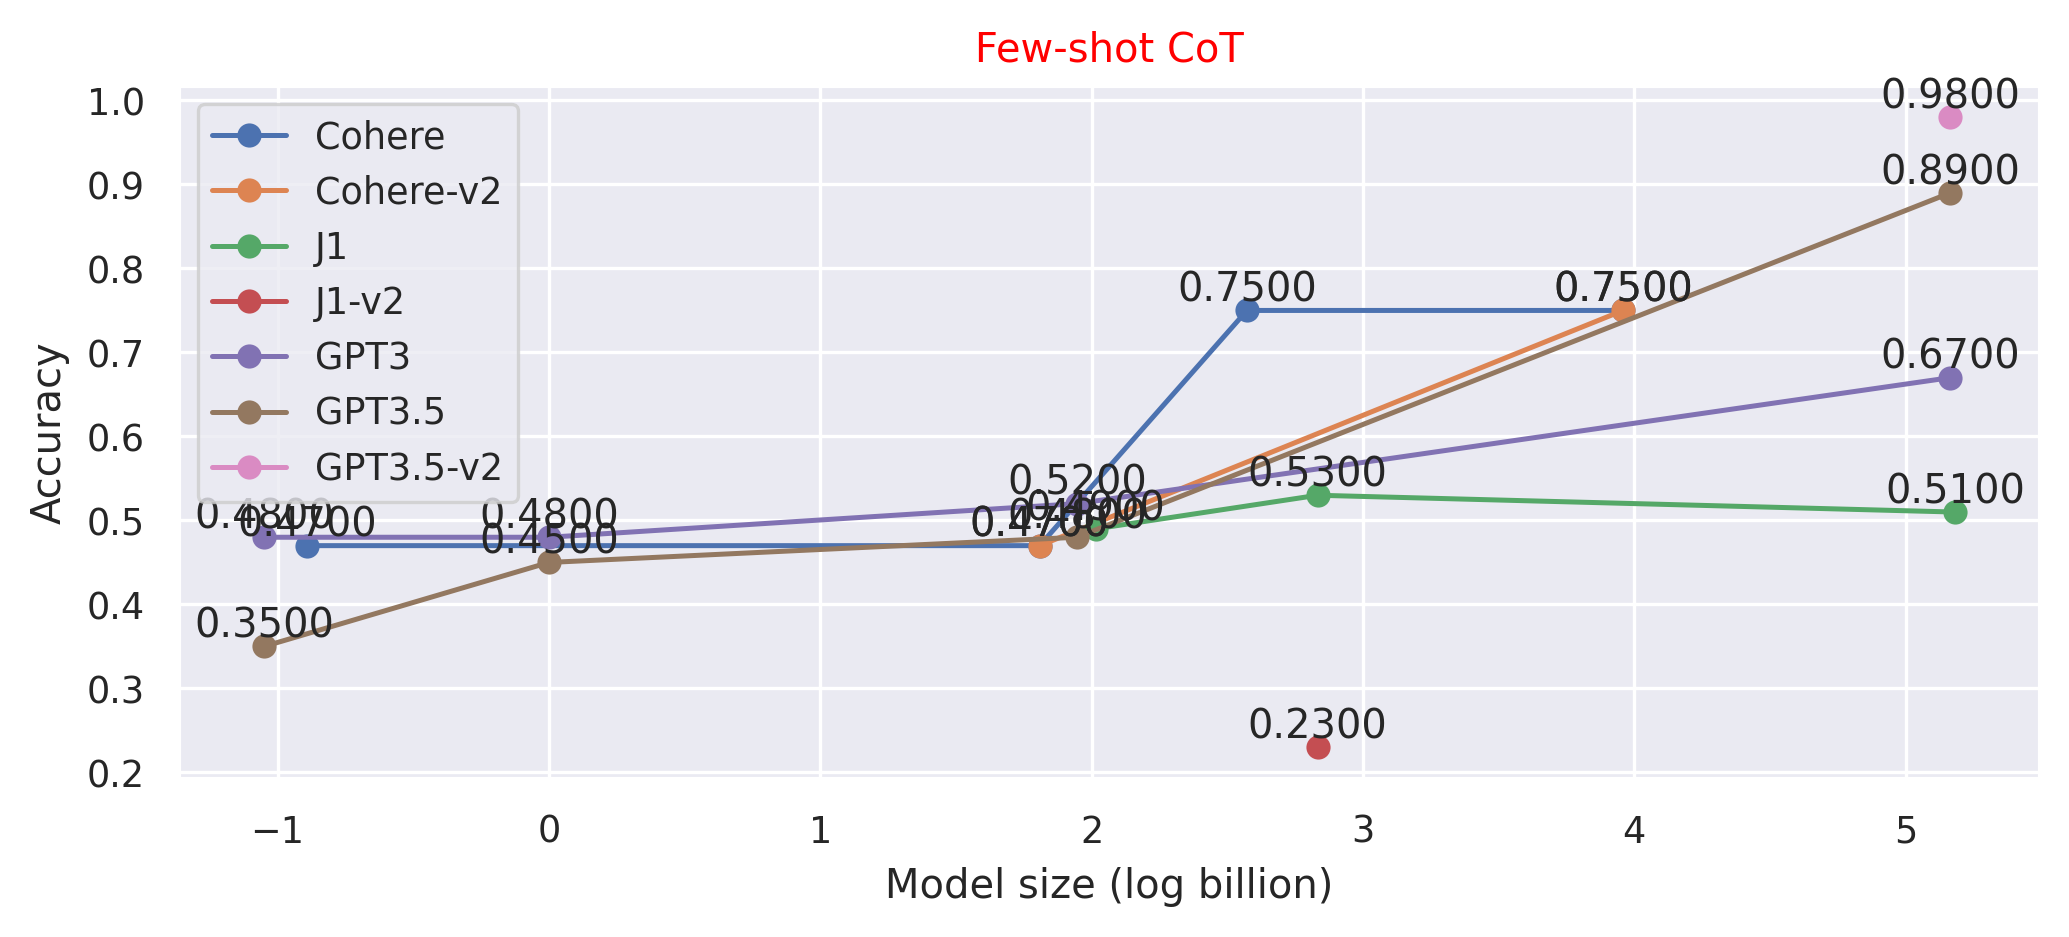

In [18]:
inputs, results = load_data(
    "../helm/benchmark_output/runs/1230_all", 
    models=[
        "cohere_small-20220720", "cohere_medium-20220720", "cohere_large-20220720", "cohere_xlarge-20220609",
        "cohere_medium-20221108", "cohere_xlarge-20221108",
        "ai21_j1-large", "ai21_j1-grande", "ai21_j1-jumbo",
        "ai21_j1-grande-v2-beta",
        "openai_ada", "openai_babbage", "openai_curie", "openai_davinci",
        "openai_text-ada-001", "openai_text-babbage-001", "openai_text-curie-001", "openai_text-davinci-001",
        "openai_text-davinci-002"
    ],
    get_inputs=False,
    folder_filter=lambda x: "cot=true" in x
)
print(len(results), len(results[0]))

probs, accs = compute_stats(inputs, results, metric_name="suffix_exact_match")
model_sizes = [
    np.log(0.41), np.log(6.1), np.log(13.1), np.log(52.4),
    np.log(6.1), np.log(52.4),
    np.log(7.5), np.log(17), np.log(178),
    np.log(17),
    np.log(0.35), np.log(1), np.log(7), np.log(175),
    np.log(0.35), np.log(1), np.log(7), np.log(175),
    np.log(175),
]

plot_multi_curves(
    [accs[:4], accs[4:6], accs[6:9], accs[9:10], accs[10:14], accs[14:18], accs[18:19]],
    [model_sizes[:4], model_sizes[4:6], model_sizes[6:9], model_sizes[9:10], model_sizes[10:14], model_sizes[14:18], model_sizes[18:19]],
    ["Cohere", "Cohere-v2", "J1", "J1-v2", "GPT3", "GPT3.5", "GPT3.5-v2"],
    "Few-shot CoT"
)

19 100


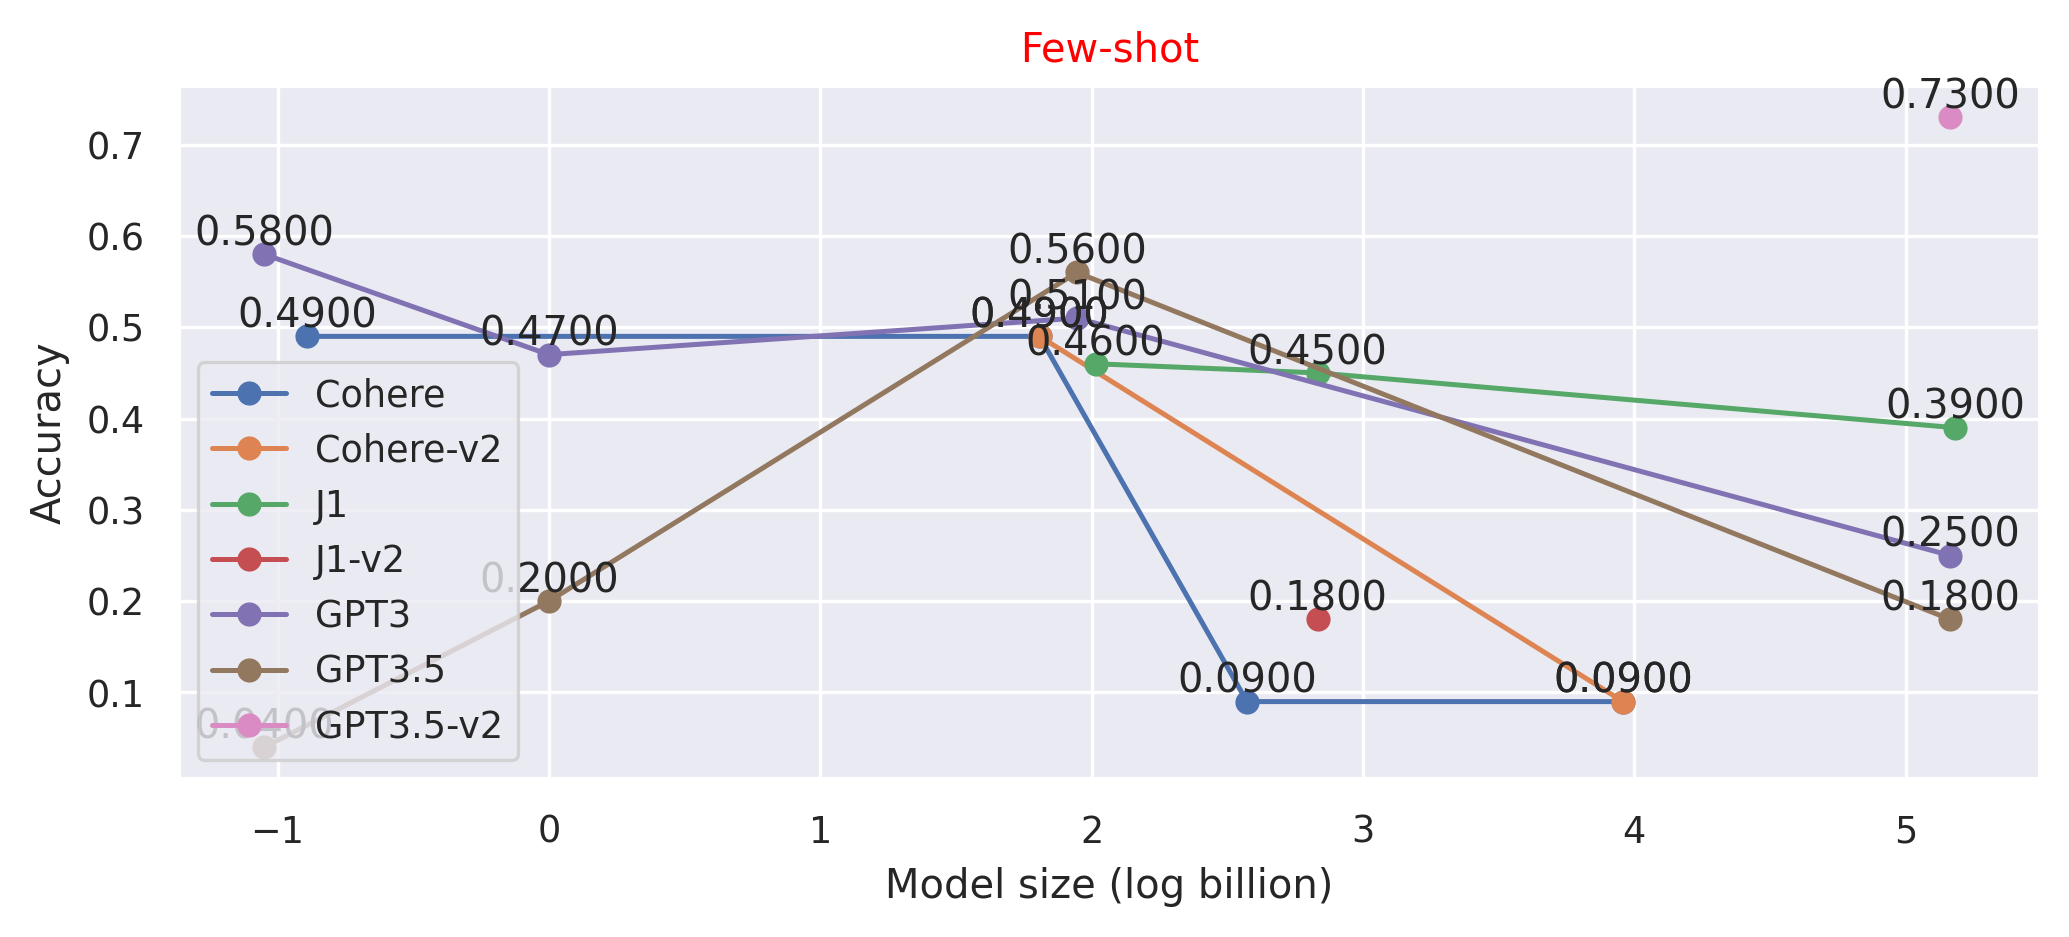

In [23]:
inputs, results = load_data(
    "../helm/benchmark_output/runs/1230_all", 
    models=[
        "cohere_small-20220720", "cohere_medium-20220720", "cohere_large-20220720", "cohere_xlarge-20220609",
        "cohere_medium-20221108", "cohere_xlarge-20221108",
        "ai21_j1-large", "ai21_j1-grande", "ai21_j1-jumbo",
        "ai21_j1-grande-v2-beta",
        "openai_ada", "openai_babbage", "openai_curie", "openai_davinci",
        "openai_text-ada-001", "openai_text-babbage-001", "openai_text-curie-001", "openai_text-davinci-001",
        "openai_text-davinci-002"
    ],
    get_inputs=False,
    folder_filter=lambda x: "cot=false" in x
)
print(len(results), len(results[0]))

probs, accs = compute_stats(inputs, results, metric_name="suffix_exact_match")
model_sizes = [
    np.log(0.41), np.log(6.1), np.log(13.1), np.log(52.4),
    np.log(6.1), np.log(52.4),
    np.log(7.5), np.log(17), np.log(178),
    np.log(17),
    np.log(0.35), np.log(1), np.log(7), np.log(175),
    np.log(0.35), np.log(1), np.log(7), np.log(175),
    np.log(175),
]

plot_multi_curves(
    [accs[:4], accs[4:6], accs[6:9], accs[9:10], accs[10:14], accs[14:18], accs[18:19]],
    [model_sizes[:4], model_sizes[4:6], model_sizes[6:9], model_sizes[9:10], model_sizes[10:14], model_sizes[14:18], model_sizes[18:19]],
    ["Cohere", "Cohere-v2", "J1", "J1-v2", "GPT3", "GPT3.5", "GPT3.5-v2"],
    "Few-shot"
)

19 100


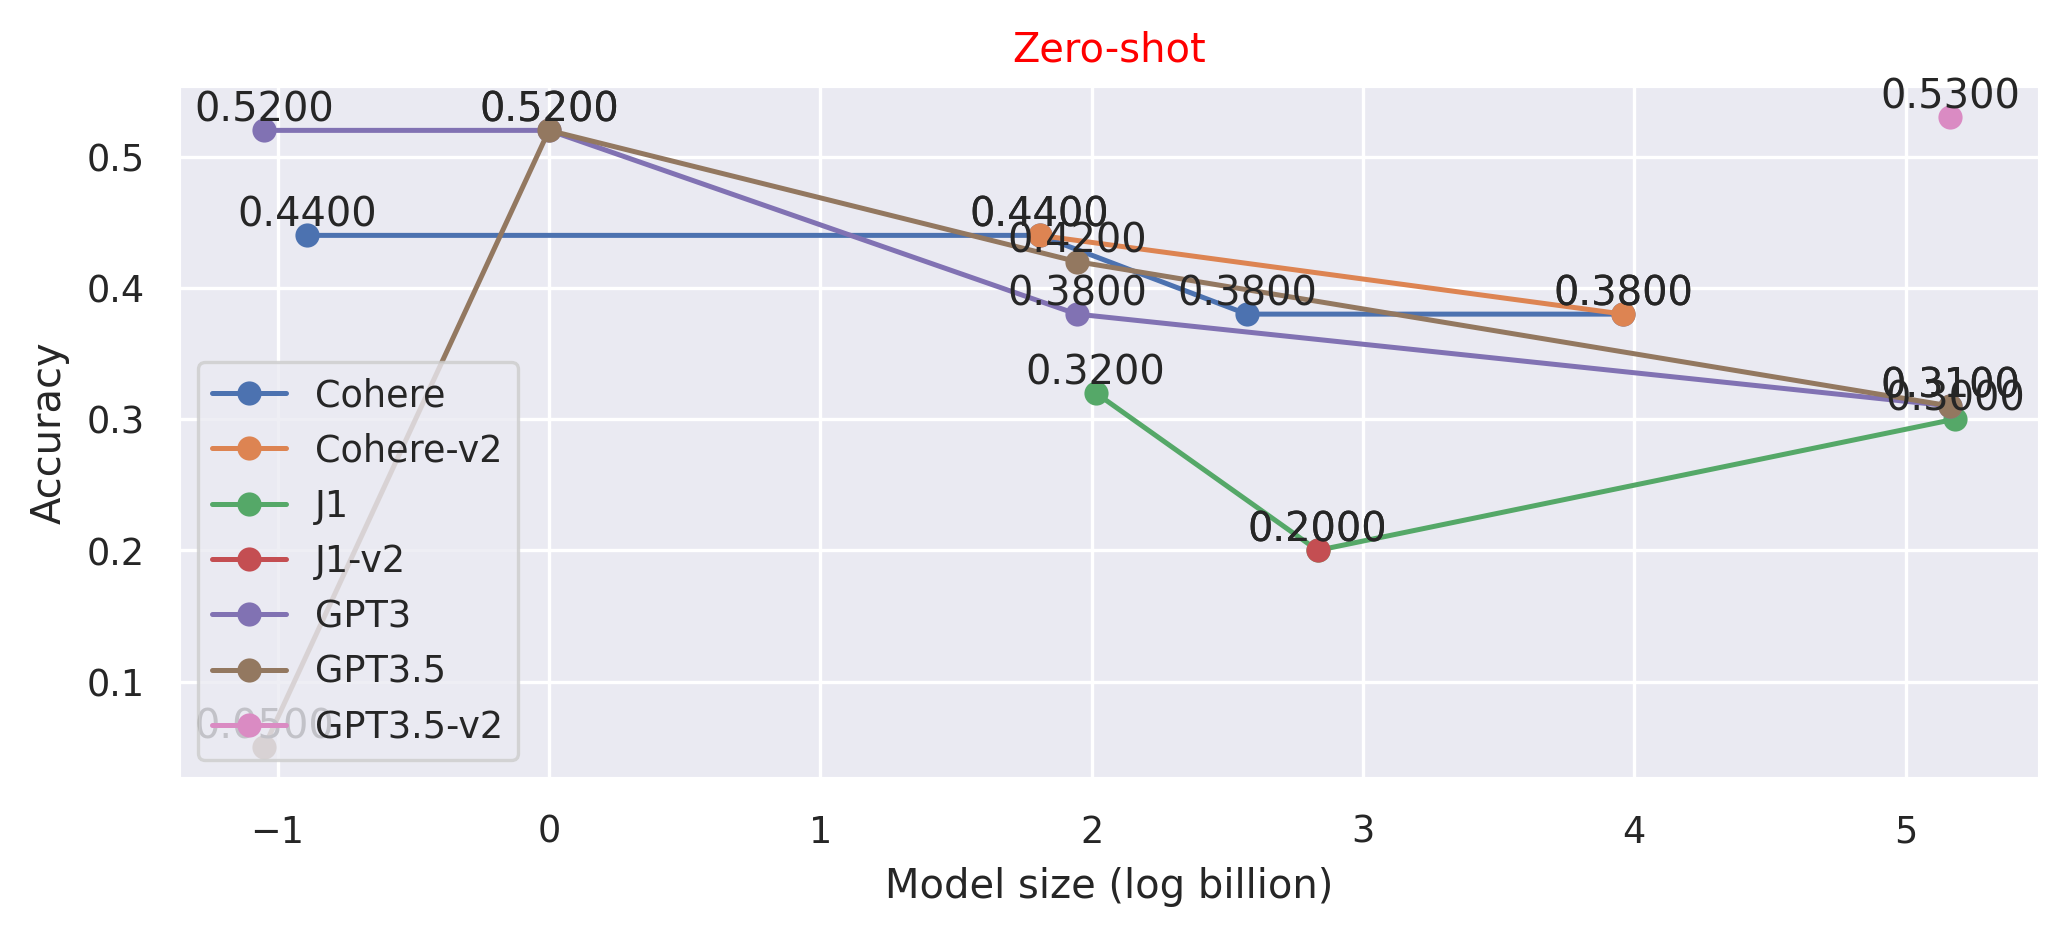

In [27]:
inputs, results = load_data(
    "../helm/benchmark_output/runs/1230_all", 
    models=[
        "cohere_small-20220720", "cohere_medium-20220720", "cohere_large-20220720", "cohere_xlarge-20220609",
        "cohere_medium-20221108", "cohere_xlarge-20221108",
        "ai21_j1-large", "ai21_j1-grande", "ai21_j1-jumbo",
        "ai21_j1-grande-v2-beta",
        "openai_ada", "openai_babbage", "openai_curie", "openai_davinci",
        "openai_text-ada-001", "openai_text-babbage-001", "openai_text-curie-001", "openai_text-davinci-001",
        "openai_text-davinci-002"
    ],
    get_inputs=False,
    folder_filter=lambda x: "method=multiple_choice_joint" in x
)
print(len(results), len(results[0]))

probs, accs = compute_stats(inputs, results, metric_name="exact_match")
model_sizes = [
    np.log(0.41), np.log(6.1), np.log(13.1), np.log(52.4),
    np.log(6.1), np.log(52.4),
    np.log(7.5), np.log(17), np.log(178),
    np.log(17),
    np.log(0.35), np.log(1), np.log(7), np.log(175),
    np.log(0.35), np.log(1), np.log(7), np.log(175),
    np.log(175),
]

plot_multi_curves(
    [accs[:4], accs[4:6], accs[6:9], accs[9:10], accs[10:14], accs[14:18], accs[18:19]],
    [model_sizes[:4], model_sizes[4:6], model_sizes[6:9], model_sizes[9:10], model_sizes[10:14], model_sizes[14:18], model_sizes[18:19]],
    ["Cohere", "Cohere-v2", "J1", "J1-v2", "GPT3", "GPT3.5", "GPT3.5-v2"],
    "Zero-shot"
)

19 100


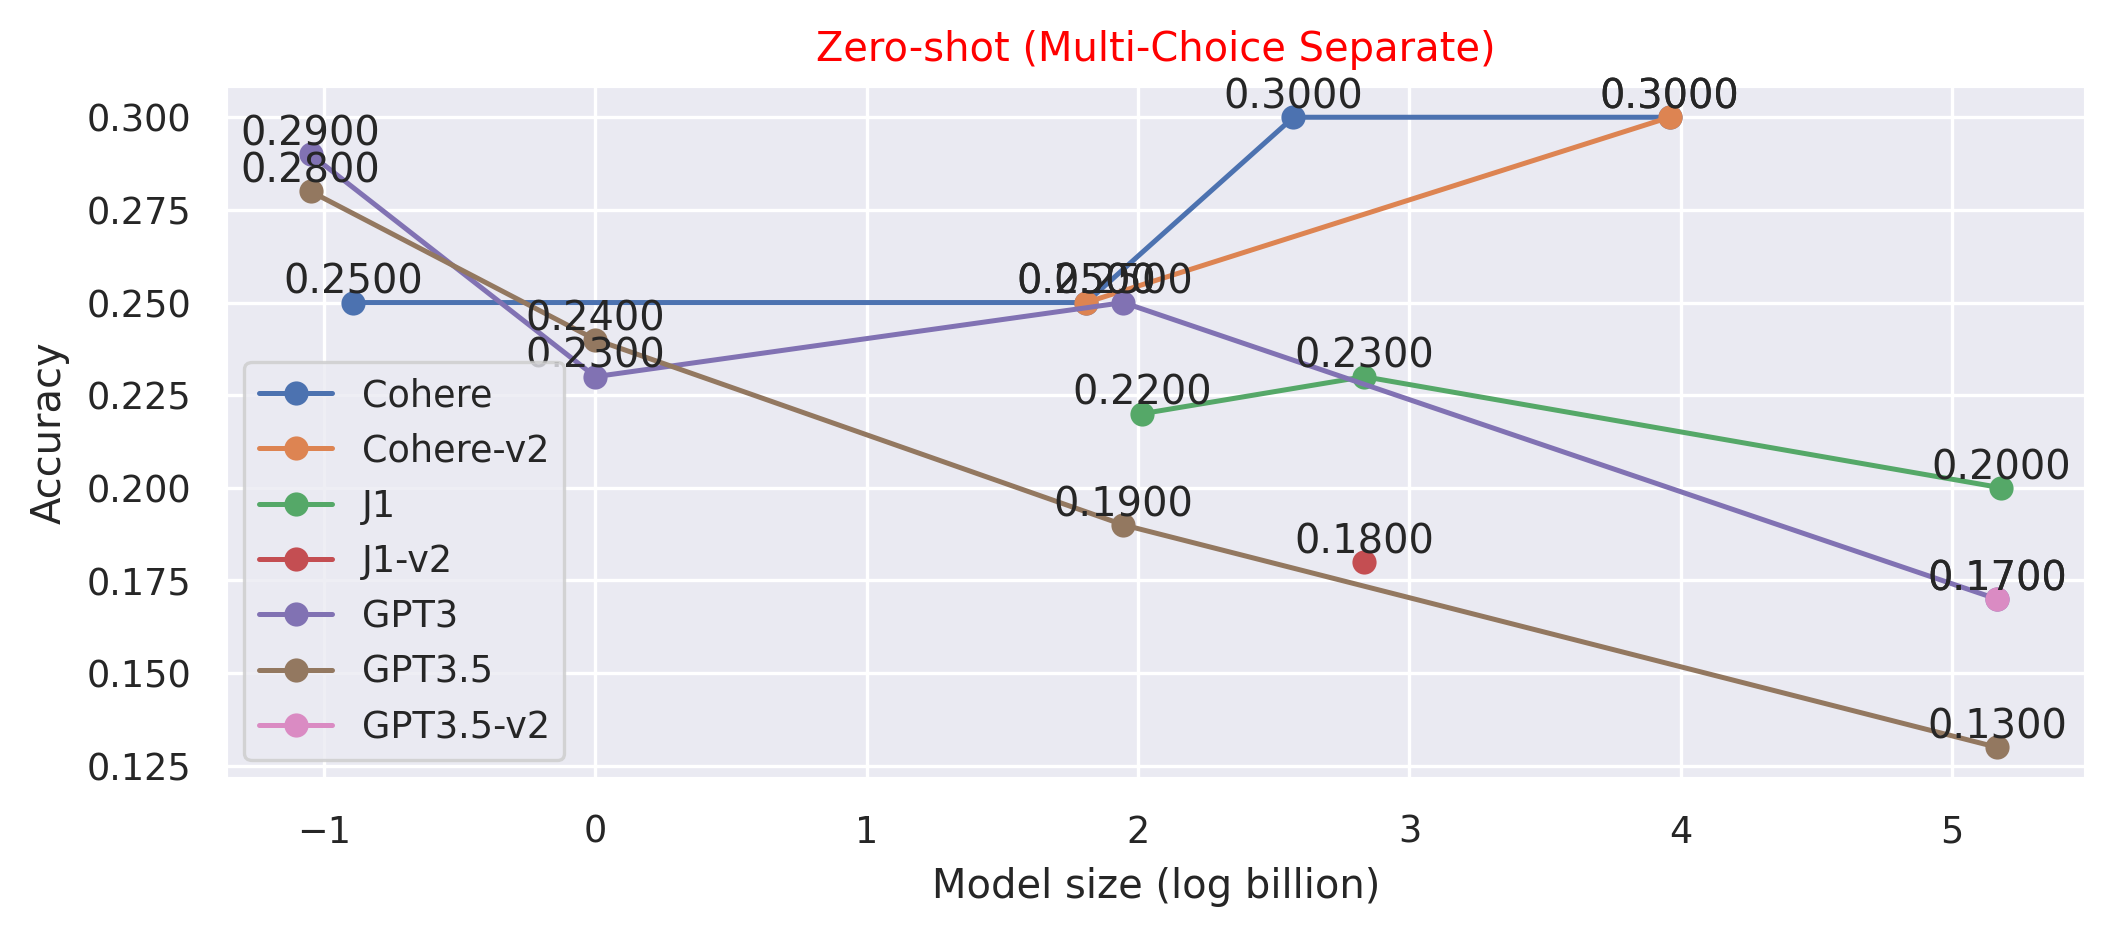

In [38]:
inputs, results = load_data(
    "../helm/benchmark_output/runs/1230_all", 
    models=[
        "cohere_small-20220720", "cohere_medium-20220720", "cohere_large-20220720", "cohere_xlarge-20220609",
        "cohere_medium-20221108", "cohere_xlarge-20221108",
        "ai21_j1-large", "ai21_j1-grande", "ai21_j1-jumbo",
        "ai21_j1-grande-v2-beta",
        "openai_ada", "openai_babbage", "openai_curie", "openai_davinci",
        "openai_text-ada-001", "openai_text-babbage-001", "openai_text-curie-001", "openai_text-davinci-001",
        "openai_text-davinci-002"
    ],
    get_inputs=False,
    folder_filter=lambda x: "method=multiple_choice_separate_original" in x
)
print(len(results), len(results[0]))

probs, accs = compute_stats(inputs, results, metric_name="exact_match")
model_sizes = [
    np.log(0.41), np.log(6.1), np.log(13.1), np.log(52.4),
    np.log(6.1), np.log(52.4),
    np.log(7.5), np.log(17), np.log(178),
    np.log(17),
    np.log(0.35), np.log(1), np.log(7), np.log(175),
    np.log(0.35), np.log(1), np.log(7), np.log(175),
    np.log(175),
]

plot_multi_curves(
    [accs[:4], accs[4:6], accs[6:9], accs[9:10], accs[10:14], accs[14:18], accs[18:19]],
    [model_sizes[:4], model_sizes[4:6], model_sizes[6:9], model_sizes[9:10], model_sizes[10:14], model_sizes[14:18], model_sizes[18:19]],
    ["Cohere", "Cohere-v2", "J1", "J1-v2", "GPT3", "GPT3.5", "GPT3.5-v2"],
    "Zero-shot (Multi-Choice Separate)"
)

19 100


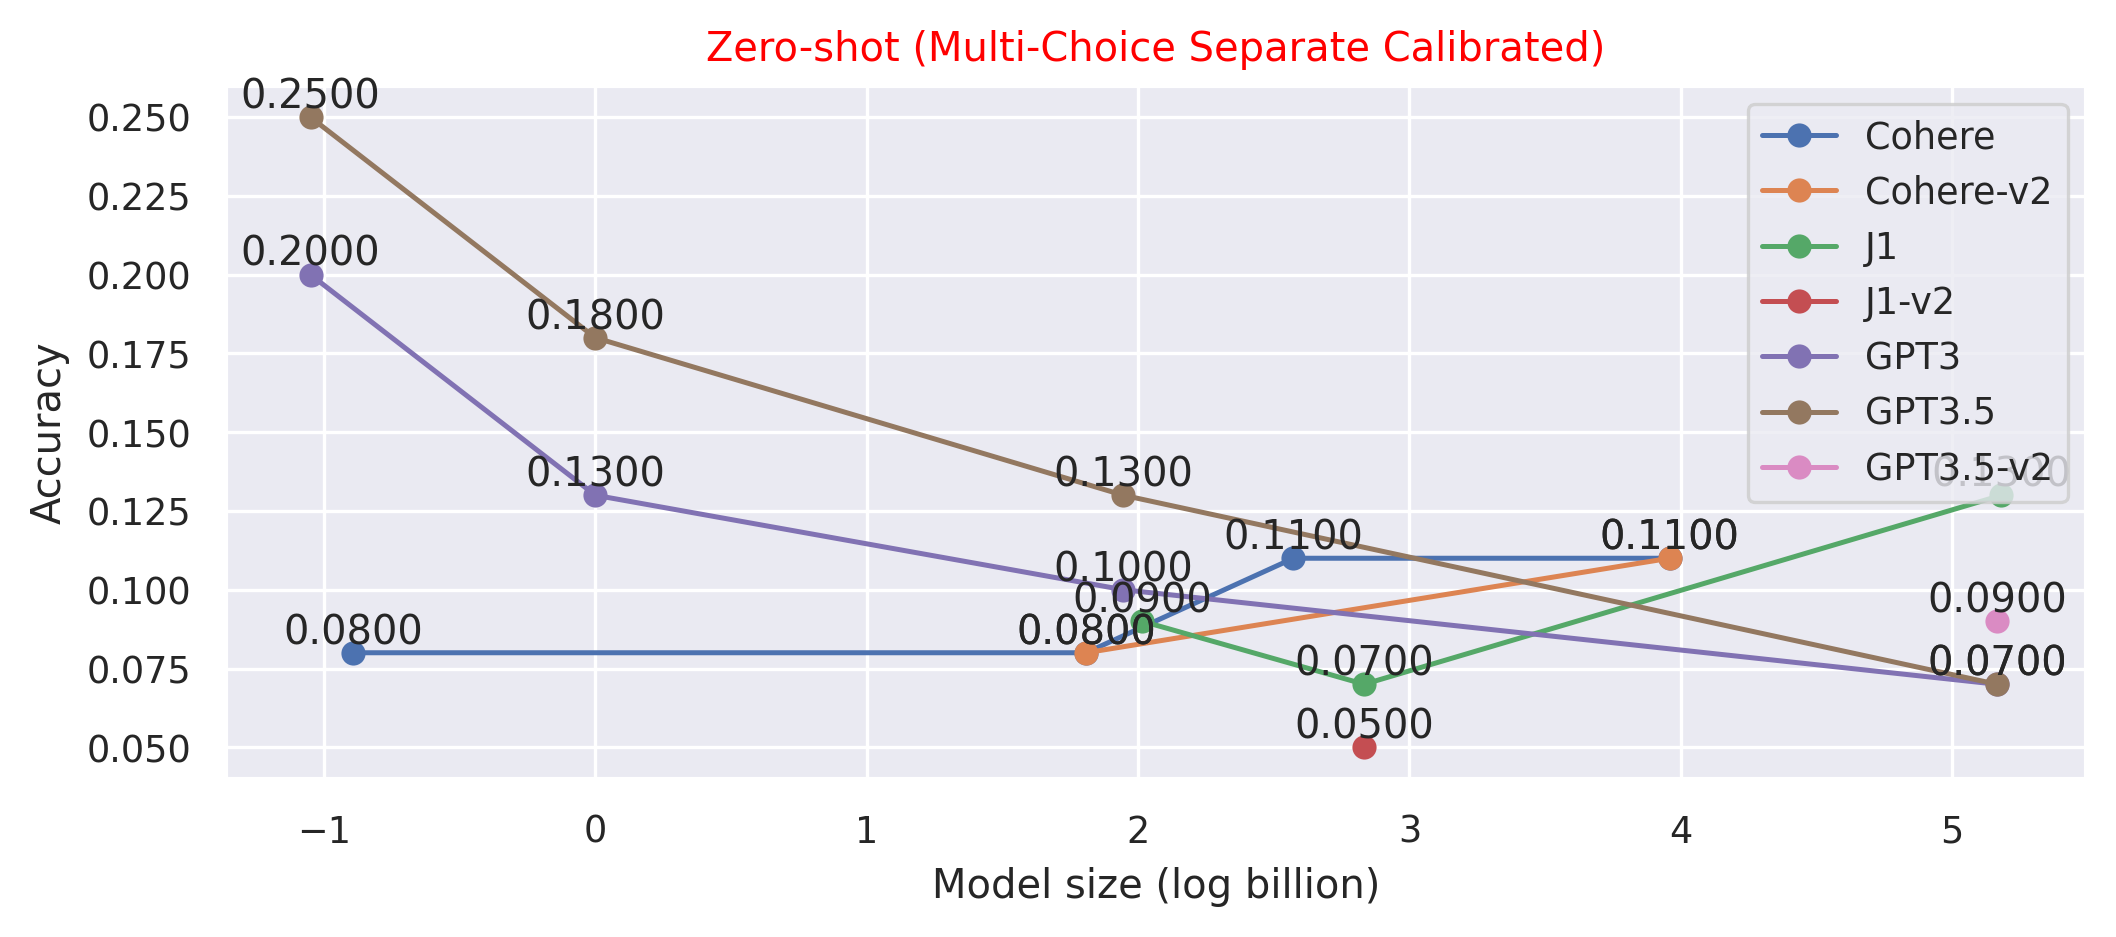

In [36]:
inputs, results = load_data(
    "../helm/benchmark_output/runs/1230_all", 
    models=[
        "cohere_small-20220720", "cohere_medium-20220720", "cohere_large-20220720", "cohere_xlarge-20220609",
        "cohere_medium-20221108", "cohere_xlarge-20221108",
        "ai21_j1-large", "ai21_j1-grande", "ai21_j1-jumbo",
        "ai21_j1-grande-v2-beta",
        "openai_ada", "openai_babbage", "openai_curie", "openai_davinci",
        "openai_text-ada-001", "openai_text-babbage-001", "openai_text-curie-001", "openai_text-davinci-001",
        "openai_text-davinci-002"
    ],
    get_inputs=False,
    folder_filter=lambda x: "method=multiple_choice_separate_calibrated" in x
)
print(len(results), len(results[0]))

probs, accs = compute_stats(inputs, results, metric_name="exact_match")
model_sizes = [
    np.log(0.41), np.log(6.1), np.log(13.1), np.log(52.4),
    np.log(6.1), np.log(52.4),
    np.log(7.5), np.log(17), np.log(178),
    np.log(17),
    np.log(0.35), np.log(1), np.log(7), np.log(175),
    np.log(0.35), np.log(1), np.log(7), np.log(175),
    np.log(175),
]

plot_multi_curves(
    [accs[:4], accs[4:6], accs[6:9], accs[9:10], accs[10:14], accs[14:18], accs[18:19]],
    [model_sizes[:4], model_sizes[4:6], model_sizes[6:9], model_sizes[9:10], model_sizes[10:14], model_sizes[14:18], model_sizes[18:19]],
    ["Cohere", "Cohere-v2", "J1", "J1-v2", "GPT3", "GPT3.5", "GPT3.5-v2"],
    "Zero-shot (Multi-Choice Separate Calibrated)"
)

# 2022/12/27 Weaker Few-shot CoT Cohere Models

6 50


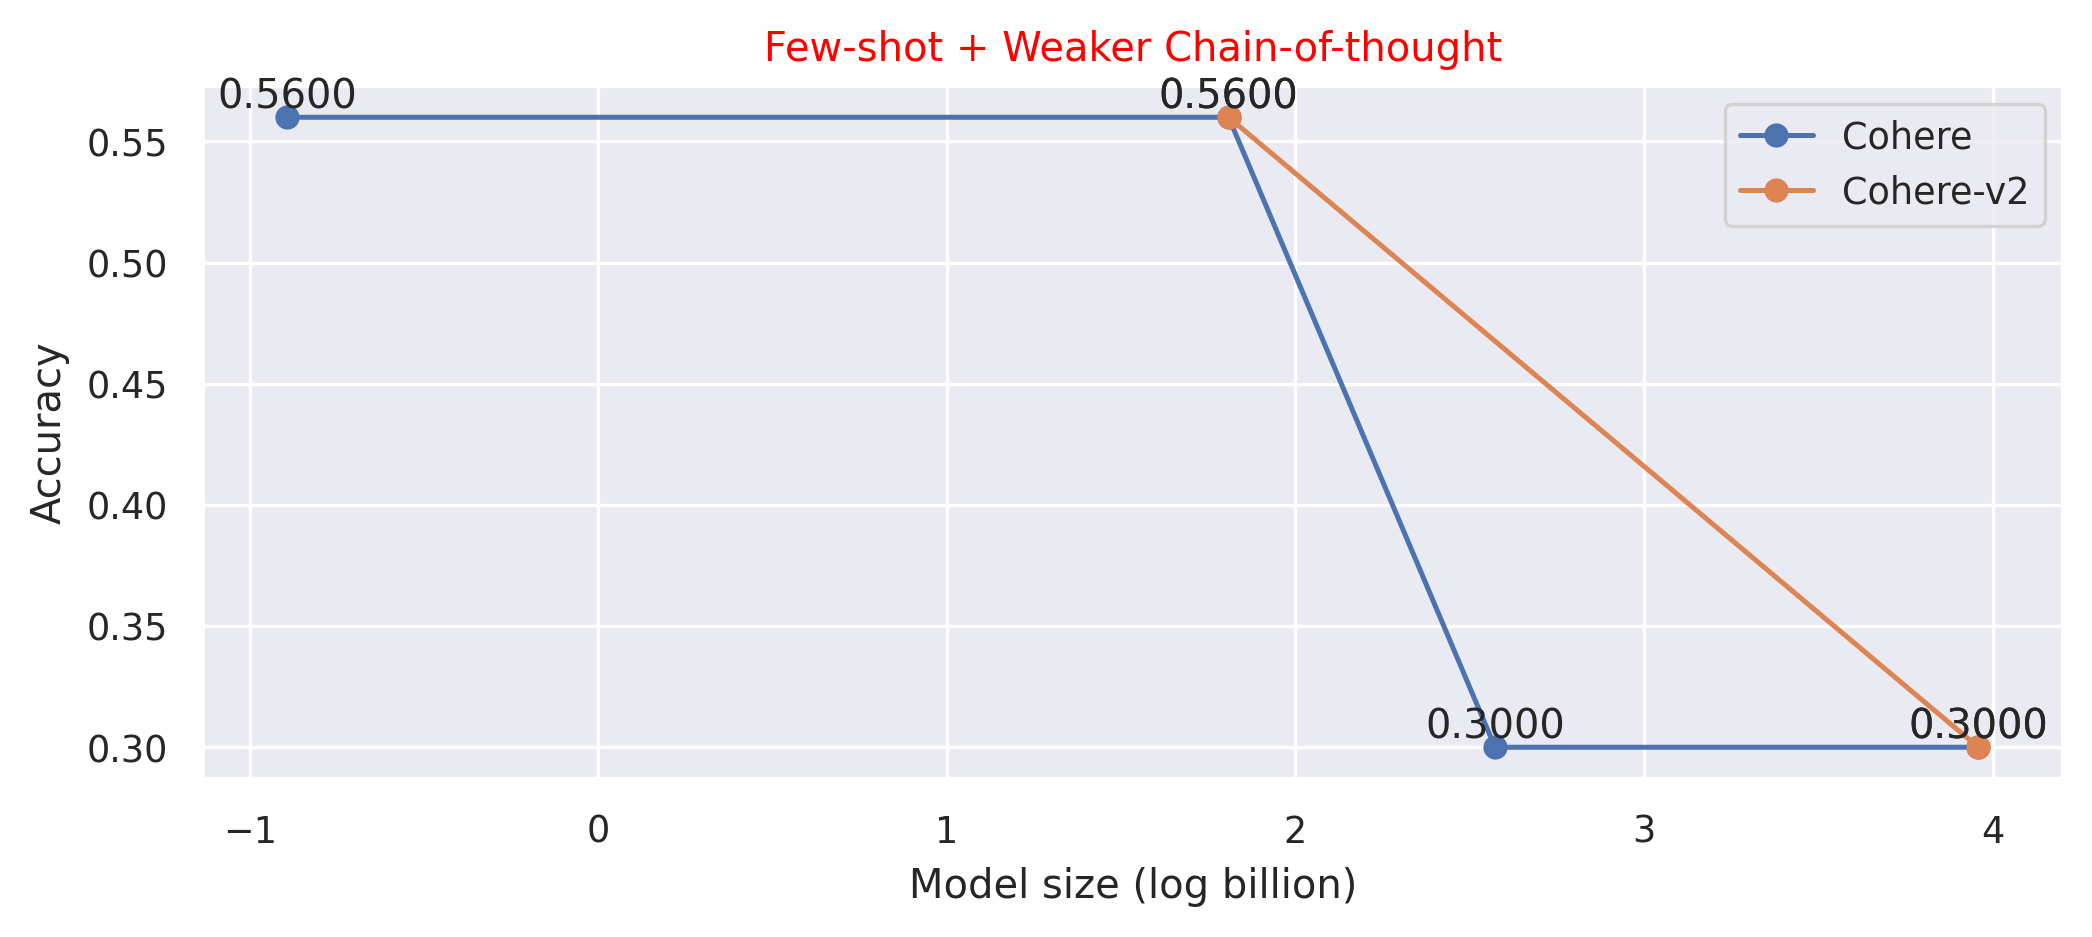

In [7]:
inputs, results = load_data(
    "../helm/benchmark_output/runs/1227_cohere_weaker_cot", 
    models=["cohere_small-20220720", "cohere_medium-20220720", "cohere_large-20220720", "cohere_xlarge-20220609", "cohere_medium-20221108", "cohere_xlarge-20221108"], 
    get_inputs=False,
    folder_filter=lambda x: "cot=true" in x
)
print(len(results), len(results[0]))
probs, accs = compute_stats(inputs, results, metric_name="suffix_exact_match")
model_sizes = [np.log(0.41), np.log(6.1), np.log(13.1), np.log(52.4), np.log(6.1), np.log(52.4)]

plot_multi_curves(
    [accs[:4], accs[4:]],
    [model_sizes[:4], model_sizes[4:]],
    ["Cohere", "Cohere-v2"],
    "Few-shot + Weaker Chain-of-thought"
)

# 2022/12/27 Weaker Few-shot CoT J1 Models

4 50


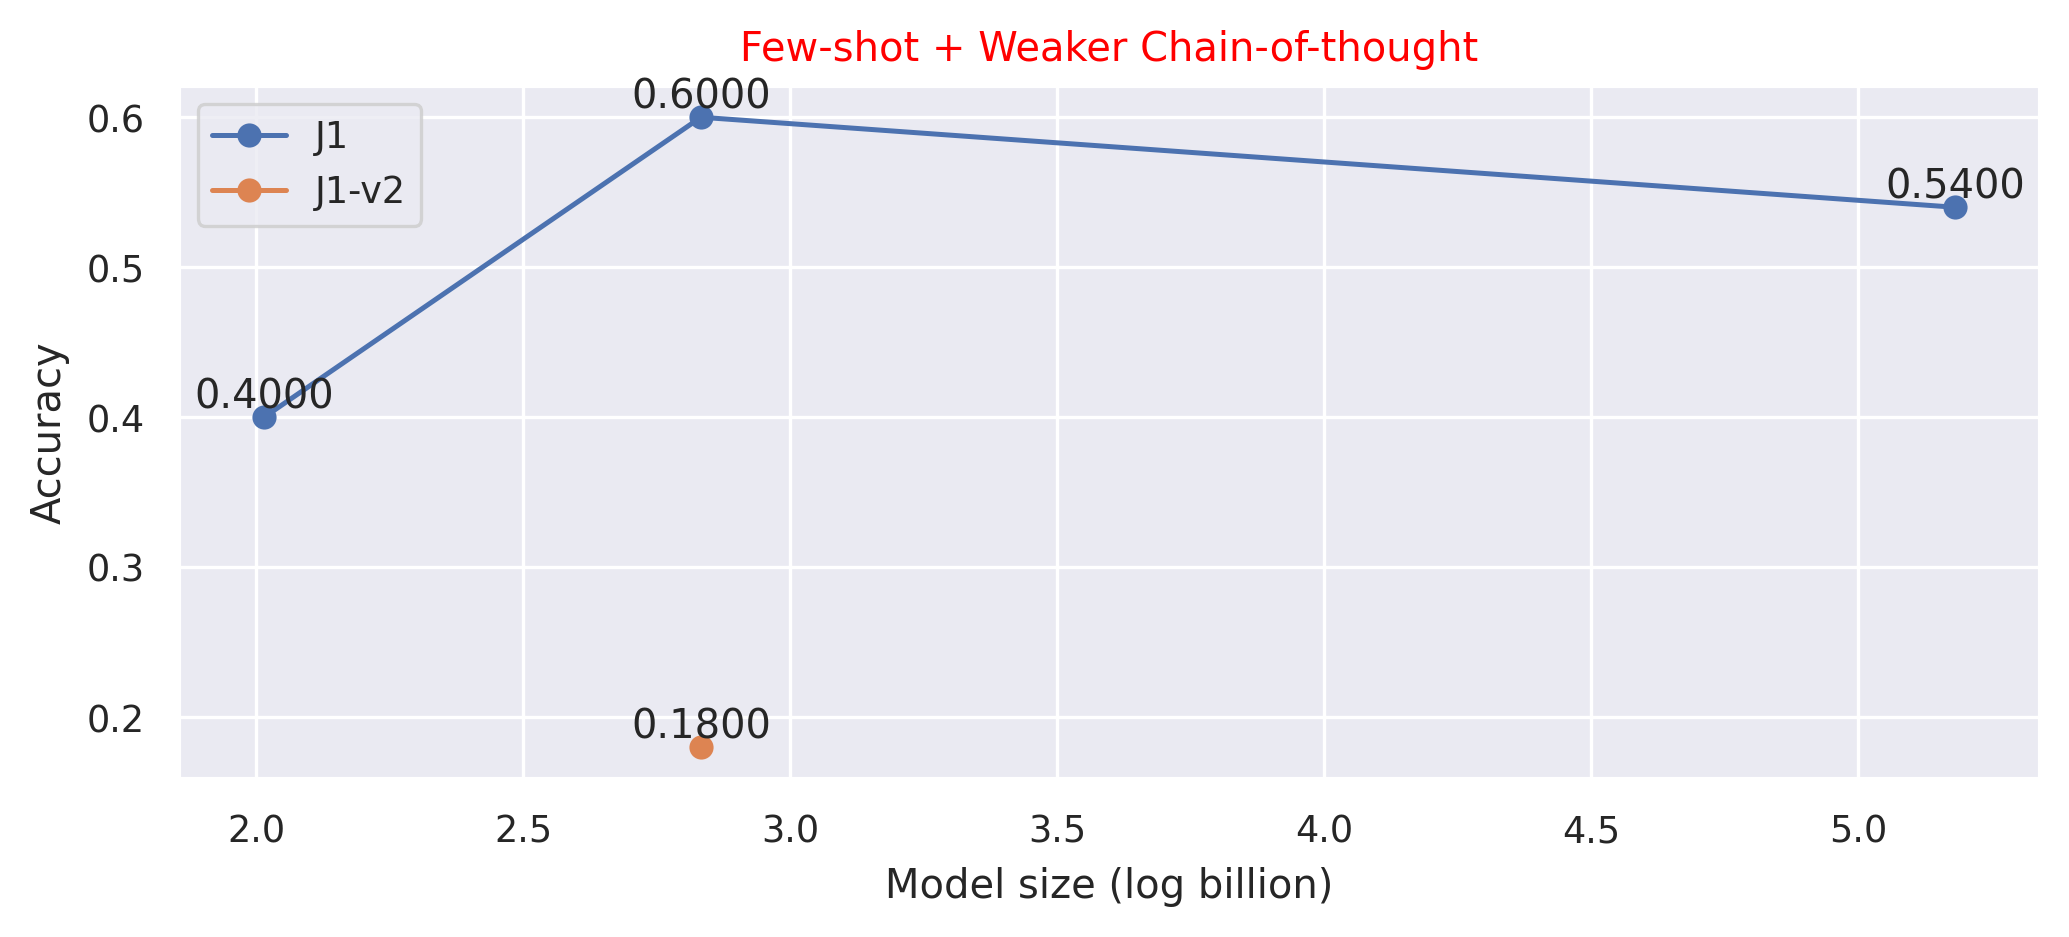

In [10]:
inputs, results = load_data(
    "../helm/benchmark_output/runs/1227_j1_weaker_cot", 
    models=["ai21_j1-large", "ai21_j1-grande", "ai21_j1-jumbo", "ai21_j1-grande-v2-beta"], 
    get_inputs=False,
    folder_filter=lambda x: "cot=true" in x
)
print(len(results), len(results[0]))
probs, accs = compute_stats(inputs, results, metric_name="suffix_exact_match")
model_sizes = [np.log(7.5), np.log(17), np.log(178), np.log(17)]

plot_multi_curves(
    [accs[:3], accs[3:4]],
    [model_sizes[:3], model_sizes[3:4]],
    ["J1", "J1-v2"],
    "Few-shot + Weaker Chain-of-thought"
)

# 2022/12/14 Weaker Few-shot CoT

9 50


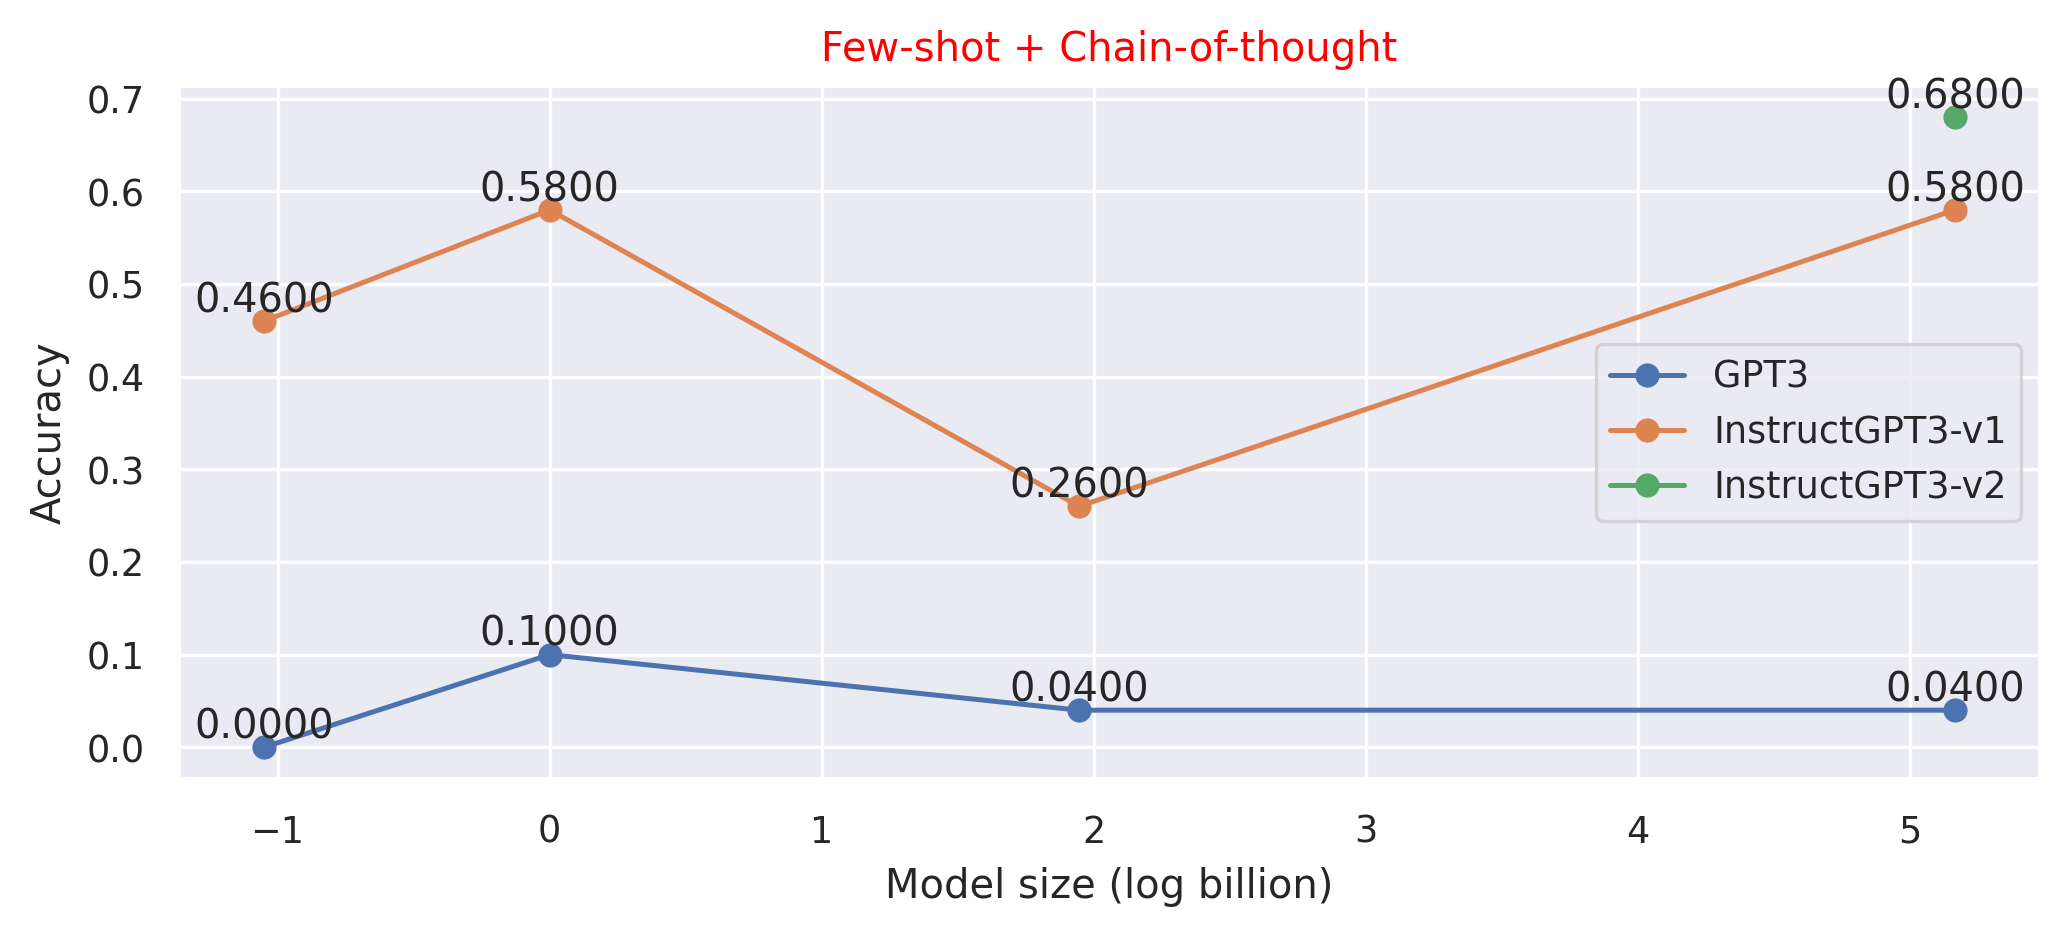

In [2]:
inputs, results = load_data(
    "../helm/benchmark_output/runs/1214_fewshot_weakercot", 
    models=["openai_ada", "openai_babbage", "openai_curie", "openai_davinci", "openai_text-ada-001", "openai_text-babbage-001", "openai_text-curie-001", "openai_text-davinci-001", "openai_text-davinci-002"], 
    get_inputs=False,
    folder_filter=lambda x: "cot=true" in x
)
print(len(results), len(results[0]))
probs, accs = compute_stats(inputs, results, metric_name="suffix_exact_match")
model_sizes = [np.log(0.35), np.log(1), np.log(7), np.log(175), np.log(0.35), np.log(1), np.log(7), np.log(175), np.log(175)]

plot_multi_curves(
    [accs[:4], accs[4:8], accs[8:]],
    [model_sizes[:4], model_sizes[4:8], model_sizes[8:]],
    ["GPT3", "InstructGPT3-v1", "InstructGPT3-v2"],
    "Few-shot + Chain-of-thought"
)

# 2022/12/13 Intention

9 50


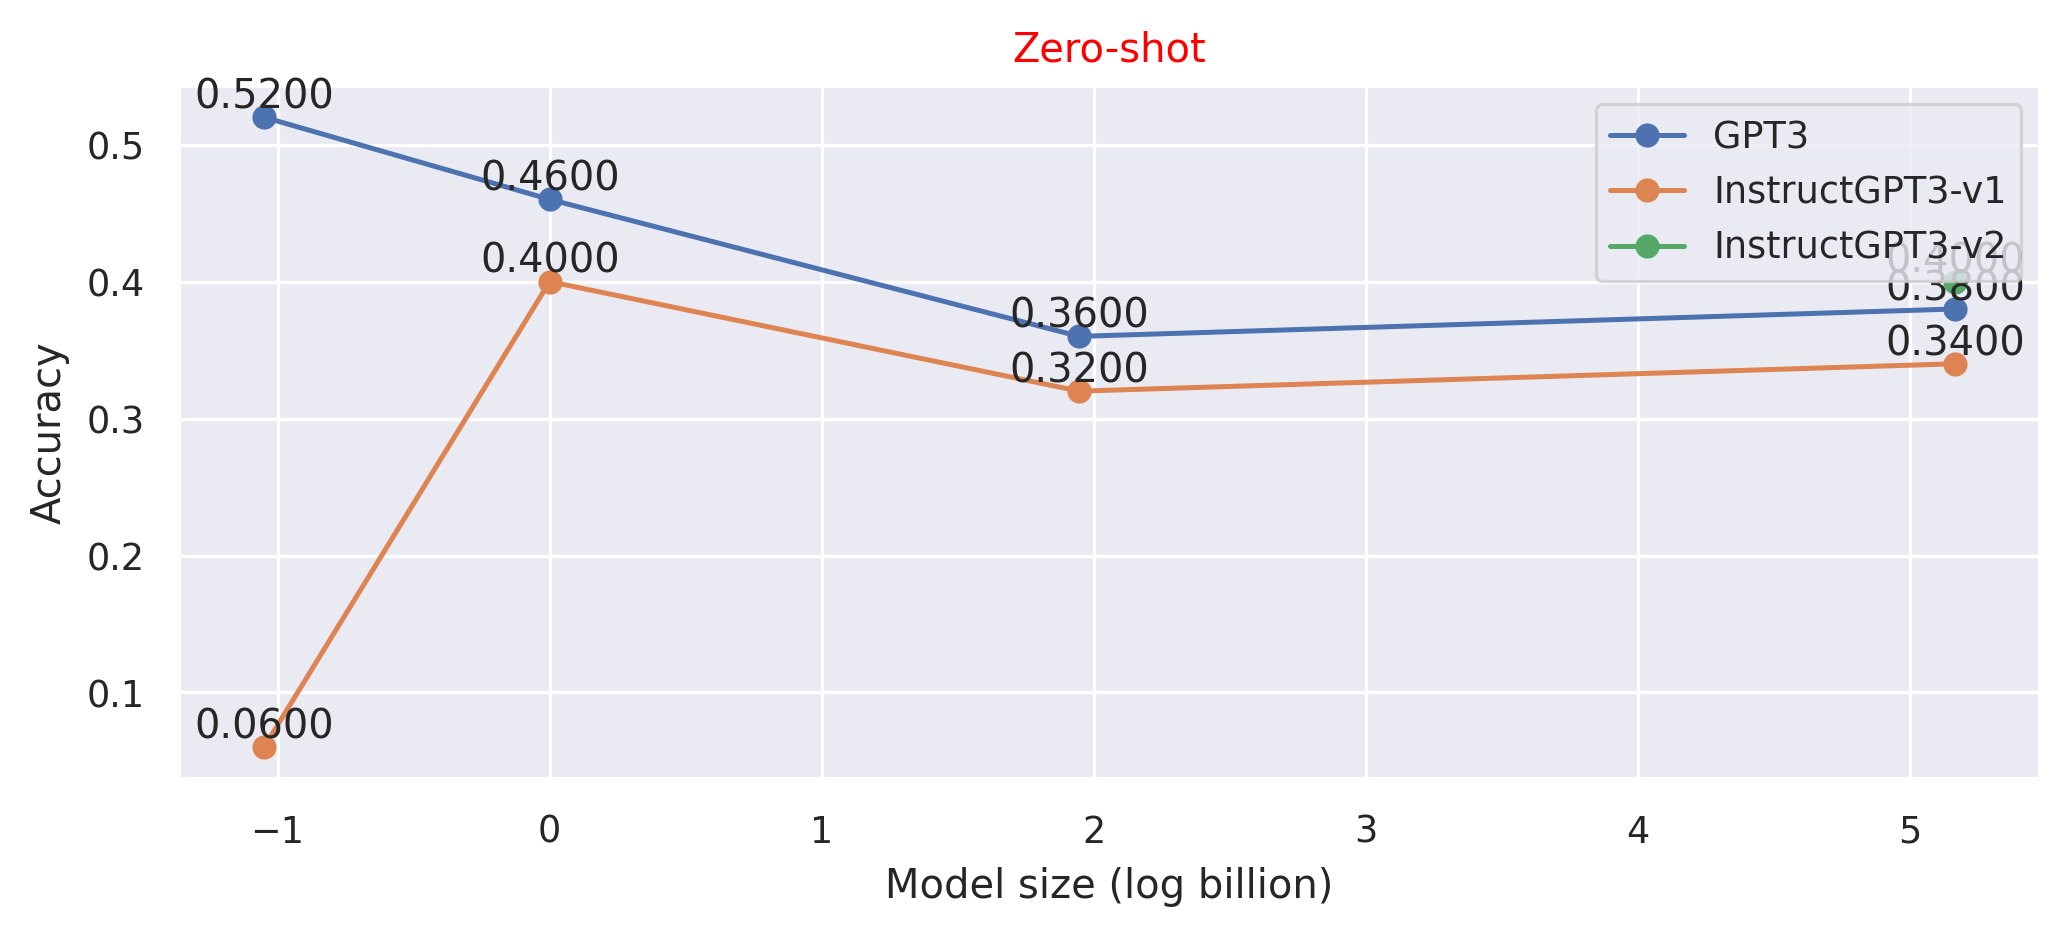

9 50


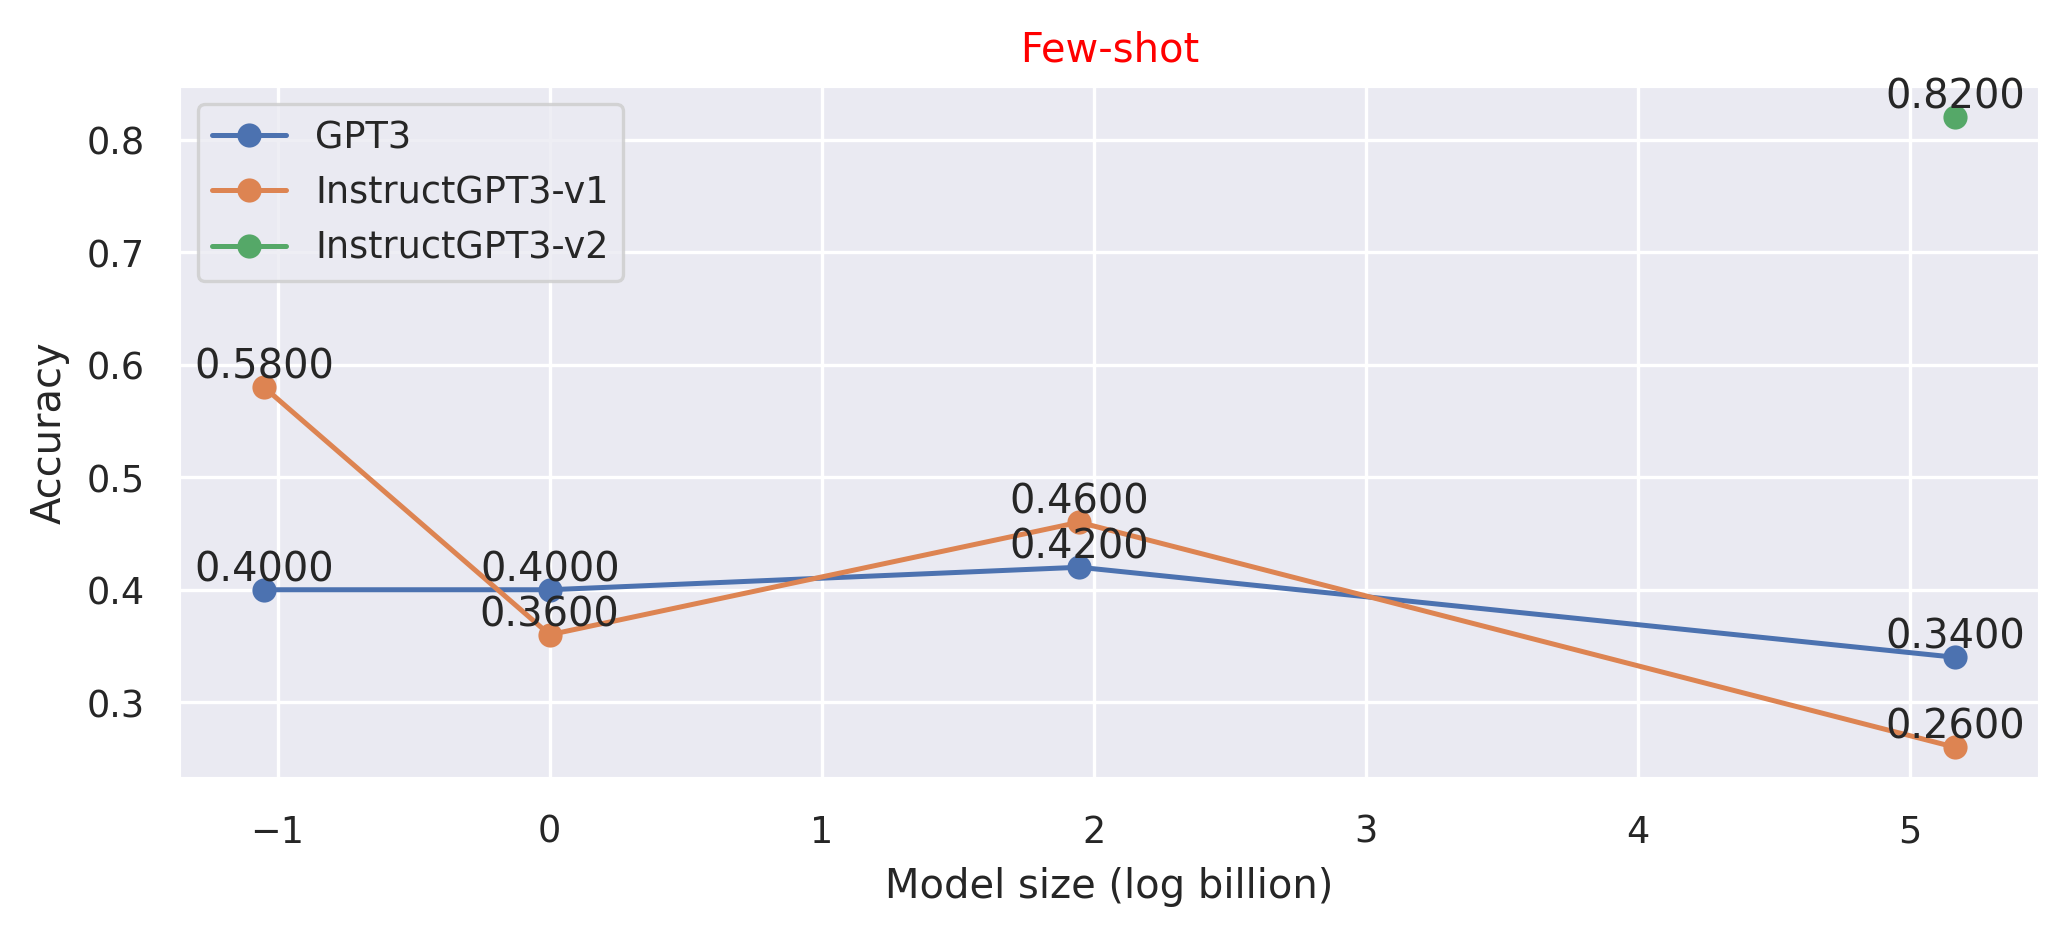

In [32]:
inputs, results = load_data(
    "../helm/benchmark_output/runs/1213_zeroshot_intention/", 
    models=["openai_ada", "openai_babbage", "openai_curie", "openai_davinci", "openai_text-ada-001", "openai_text-babbage-001", "openai_text-curie-001", "openai_text-davinci-001", "openai_text-davinci-002"], 
    get_inputs=False
)
print(len(results), len(results[0]))
probs, accs = compute_stats(inputs, results)
model_sizes = [np.log(0.35), np.log(1), np.log(7), np.log(175), np.log(0.35), np.log(1), np.log(7), np.log(175), np.log(175)]

plot_multi_curves(
    [accs[:4], accs[4:8], accs[8:]],
    [model_sizes[:4], model_sizes[4:8], model_sizes[8:]],
    ["GPT3", "InstructGPT3-v1", "InstructGPT3-v2"],
    "Zero-shot"
)

inputs, results = load_data(
    "../helm/benchmark_output/runs/1213_fewshot_intention/", 
    models=["openai_ada", "openai_babbage", "openai_curie", "openai_davinci", "openai_text-ada-001", "openai_text-babbage-001", "openai_text-curie-001", "openai_text-davinci-001", "openai_text-davinci-002"], 
    get_inputs=False,
    folder_filter=lambda x: "cot=false" in x
)
print(len(results), len(results[0]))
probs, accs = compute_stats(inputs, results, metric_name="suffix_exact_match")
model_sizes = [np.log(0.35), np.log(1), np.log(7), np.log(175), np.log(0.35), np.log(1), np.log(7), np.log(175), np.log(175)]

plot_multi_curves(
    [accs[:4], accs[4:8], accs[8:]],
    [model_sizes[:4], model_sizes[4:8], model_sizes[8:]],
    ["GPT3", "InstructGPT3-v1", "InstructGPT3-v2"],
    "Few-shot"
)

# 2022/12/10 Few-shot + Chain-of-thought NeQA

9 50


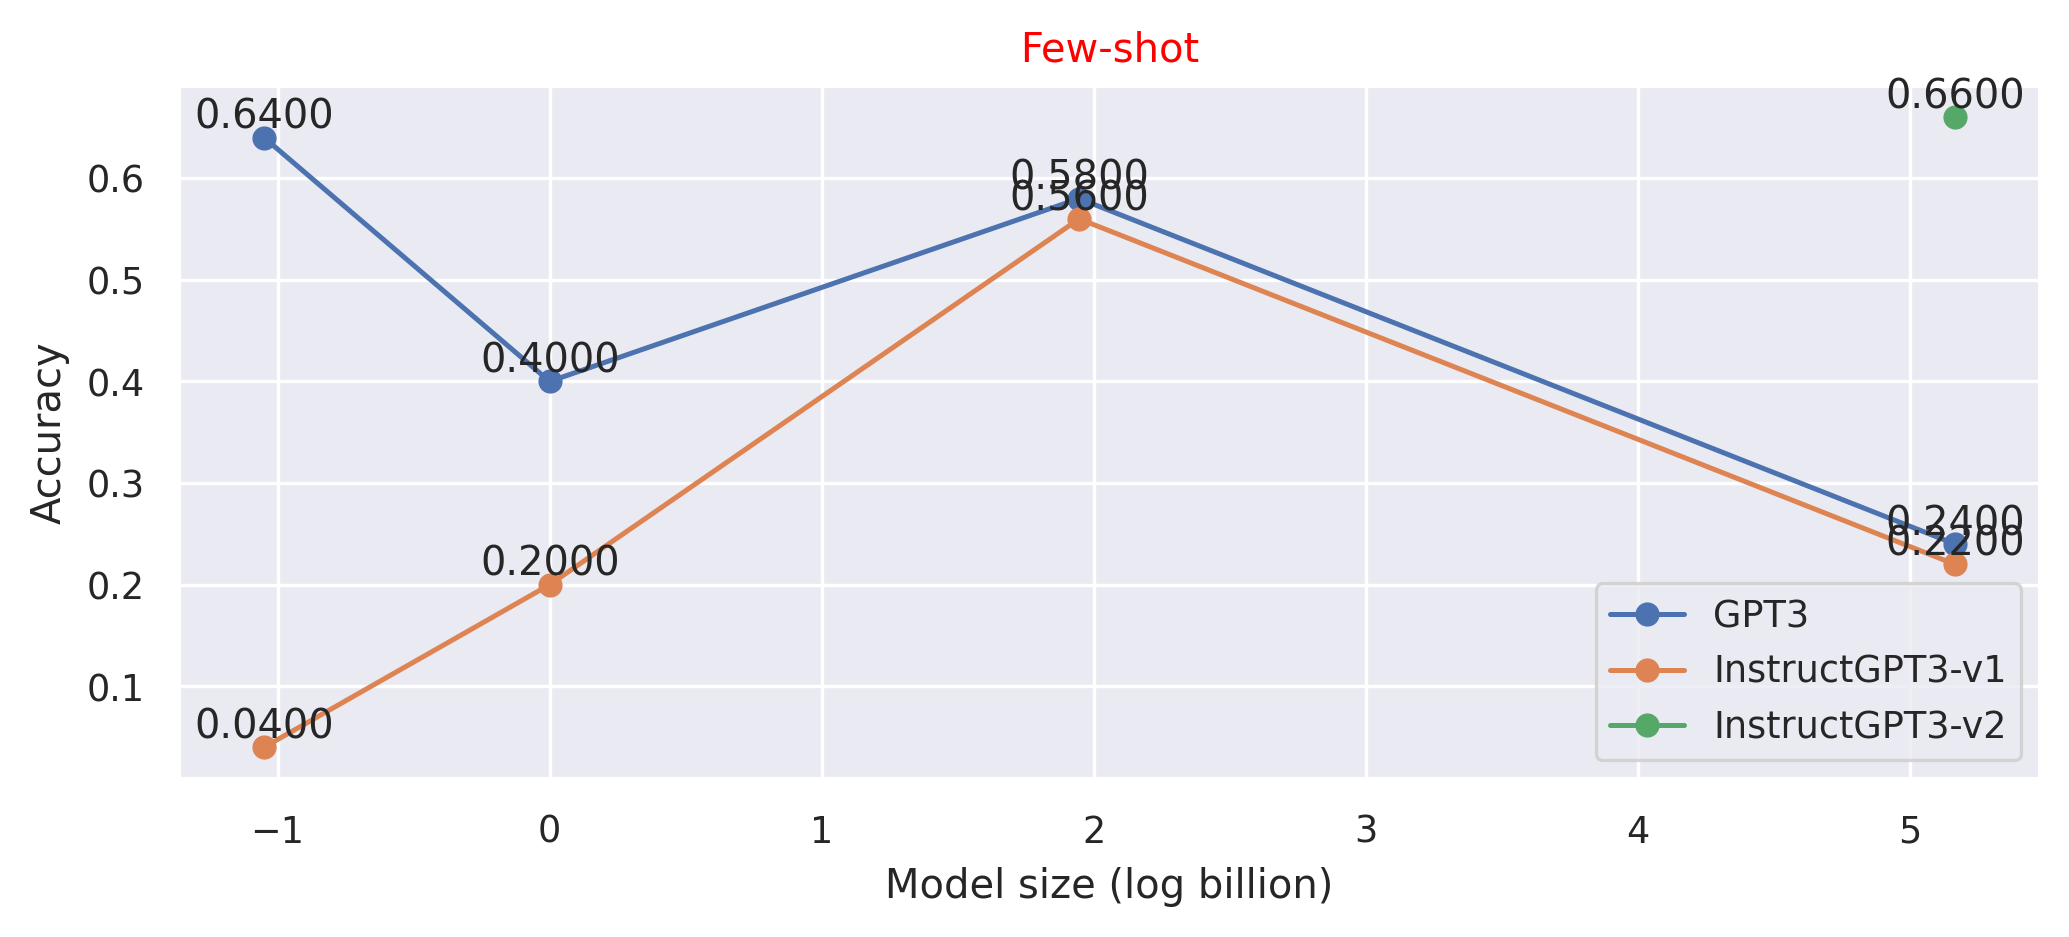

9 50


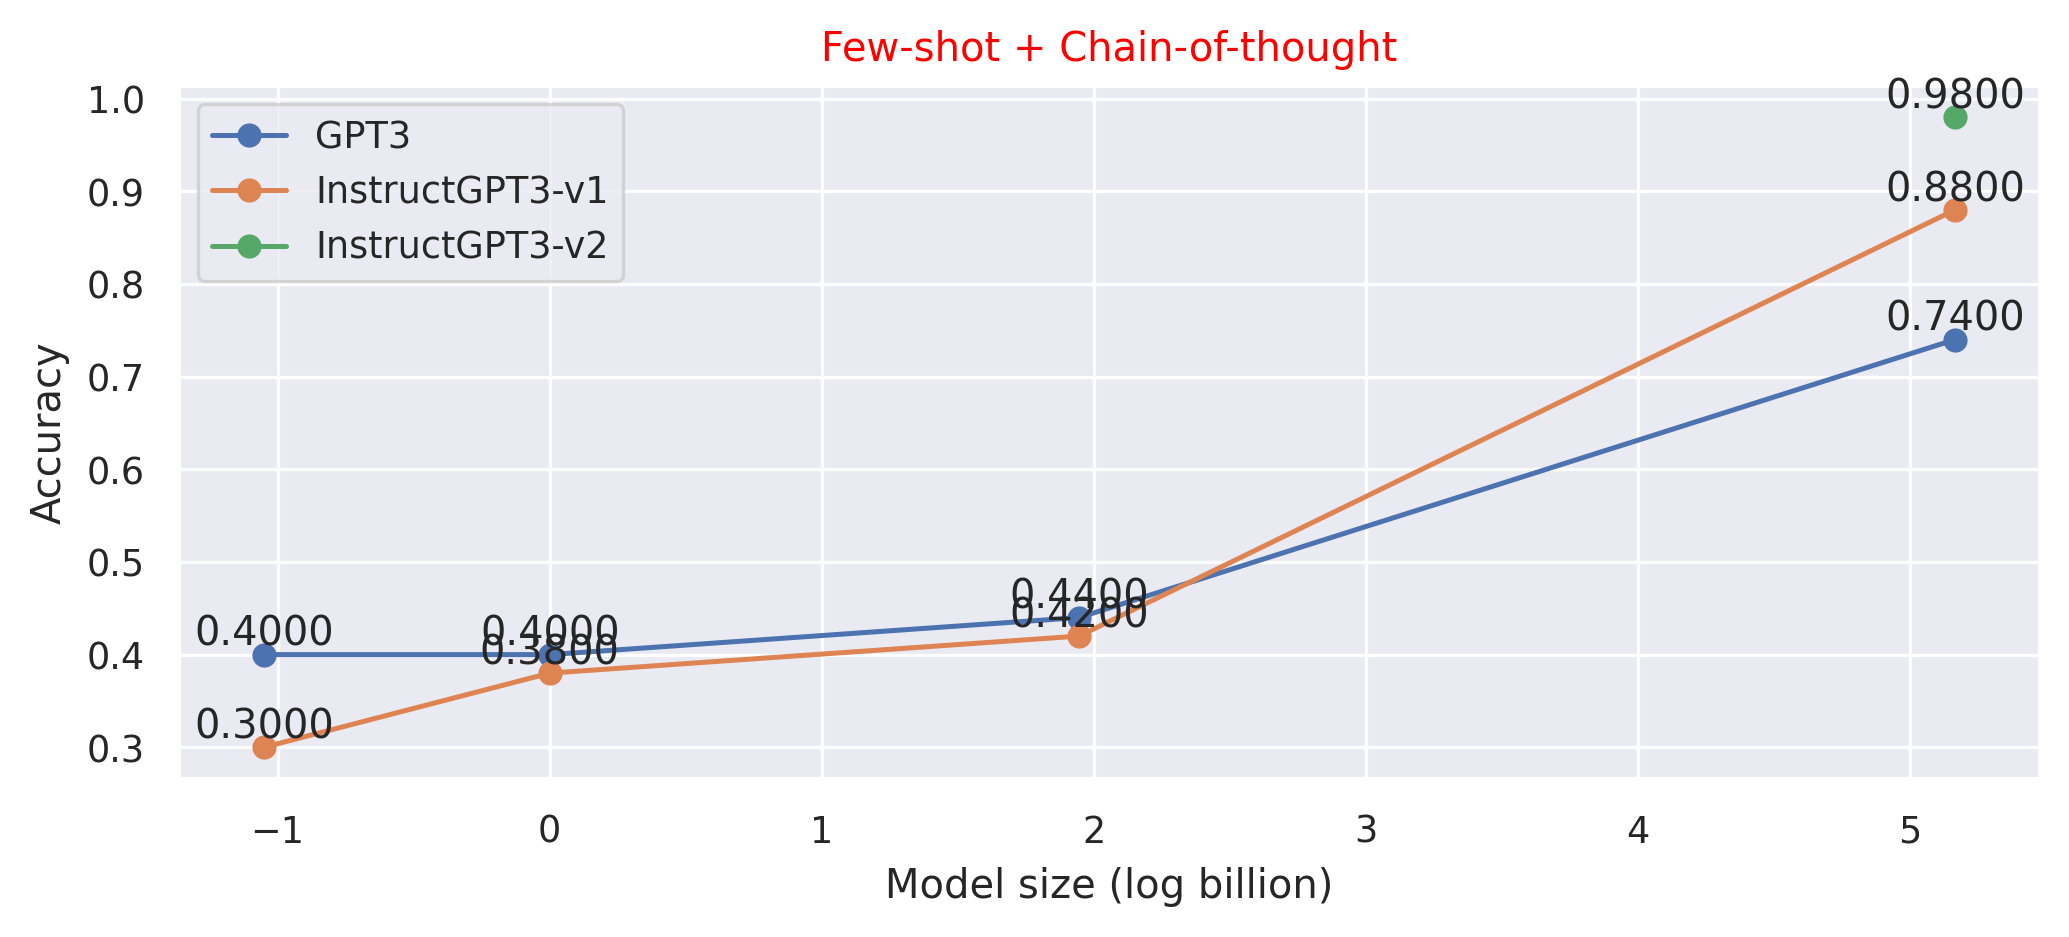

In [27]:
inputs, results = load_data(
    "../helm/benchmark_output/runs/1210_50instances/", 
    models=["openai_ada", "openai_babbage", "openai_curie", "openai_davinci", "openai_text-ada-001", "openai_text-babbage-001", "openai_text-curie-001", "openai_text-davinci-001", "openai_text-davinci-002"], 
    get_inputs=False,
    folder_filter=lambda x: "cot=false" in x
)
print(len(results), len(results[0]))
probs, accs = compute_stats(inputs, results, metric_name="suffix_exact_match")
model_sizes = [np.log(0.35), np.log(1), np.log(7), np.log(175), np.log(0.35), np.log(1), np.log(7), np.log(175), np.log(175)]

plot_multi_curves(
    [accs[:4], accs[4:8], accs[8:]],
    [model_sizes[:4], model_sizes[4:8], model_sizes[8:]],
    ["GPT3", "InstructGPT3-v1", "InstructGPT3-v2"],
    "Few-shot"
)


inputs, results = load_data(
    "../helm/benchmark_output/runs/1210_50instances/", 
    models=["openai_ada", "openai_babbage", "openai_curie", "openai_davinci", "openai_text-ada-001", "openai_text-babbage-001", "openai_text-curie-001", "openai_text-davinci-001", "openai_text-davinci-002"], 
    get_inputs=False,
    folder_filter=lambda x: "cot=true" in x
)
print(len(results), len(results[0]))
probs, accs = compute_stats(inputs, results, metric_name="suffix_exact_match")
model_sizes = [np.log(0.35), np.log(1), np.log(7), np.log(175), np.log(0.35), np.log(1), np.log(7), np.log(175), np.log(175)]

plot_multi_curves(
    [accs[:4], accs[4:8], accs[8:]],
    [model_sizes[:4], model_sizes[4:8], model_sizes[8:]],
    ["GPT3", "InstructGPT3-v1", "InstructGPT3-v2"],
    "Few-shot + Chain-of-thought"
)

# 2022/12/09 NeQA

9 50


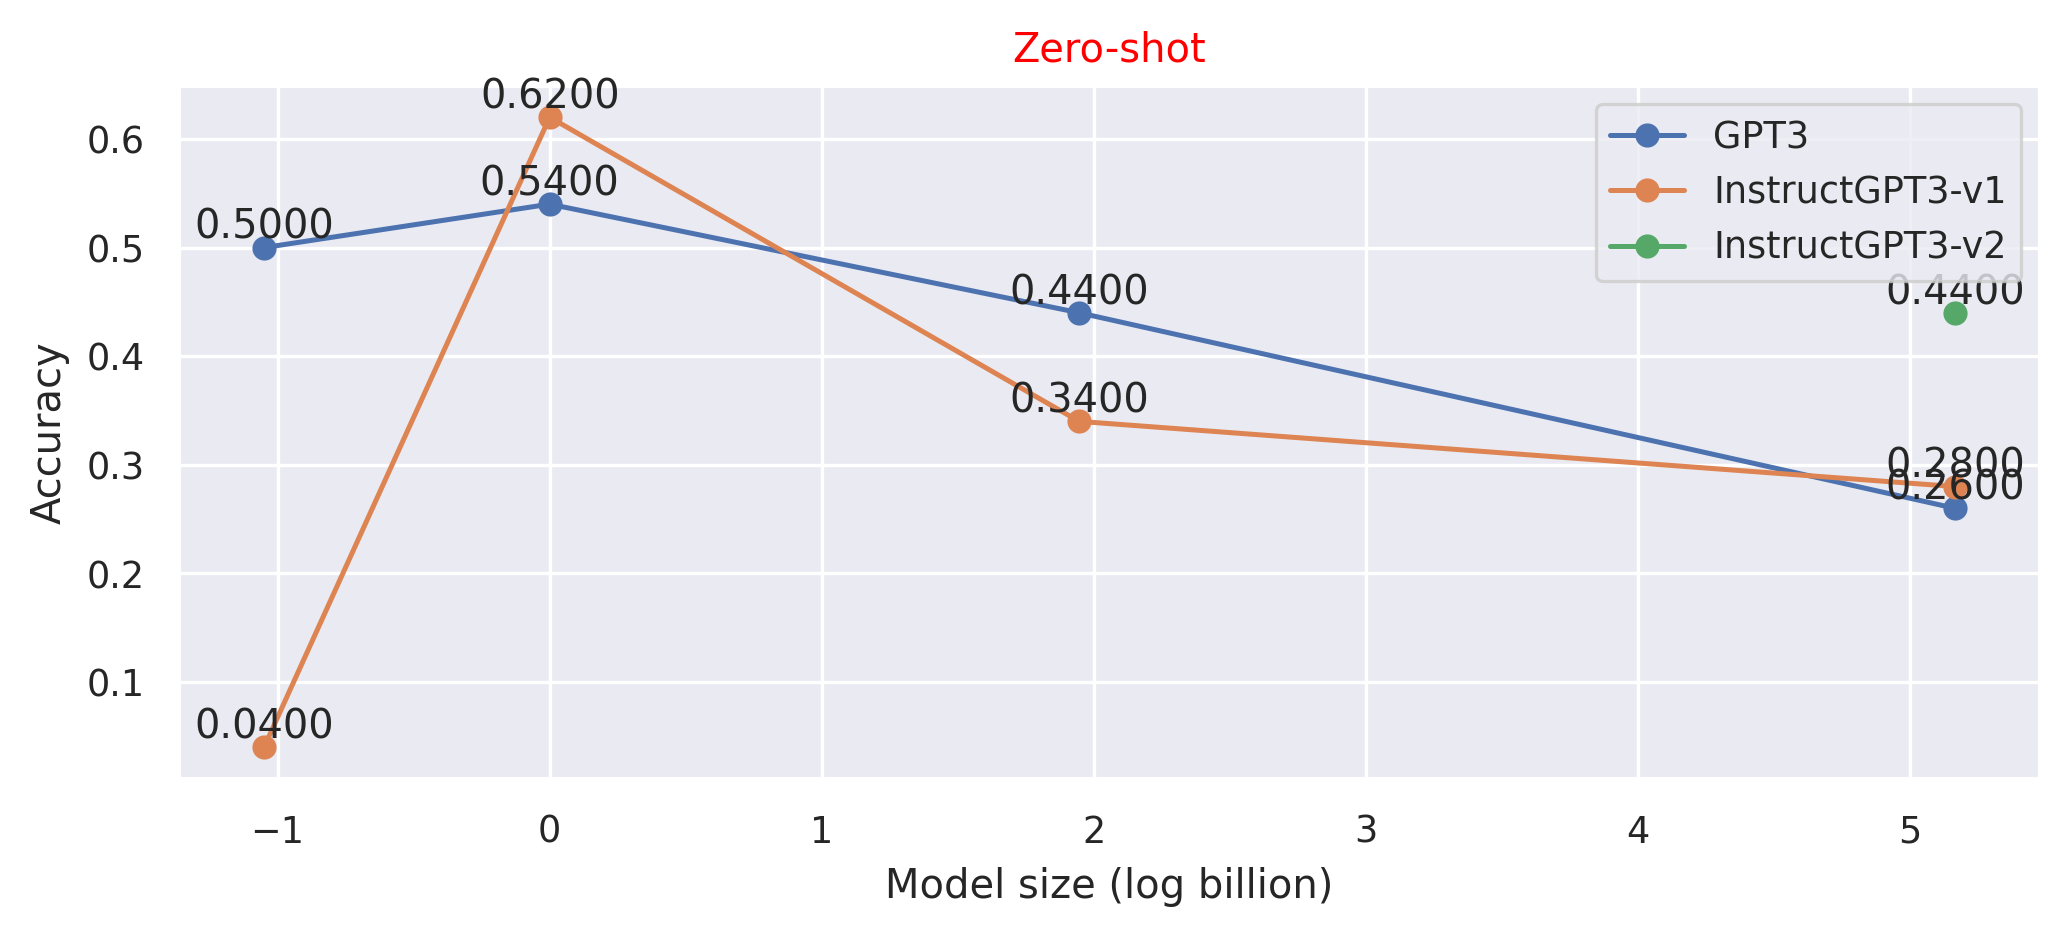

In [28]:
inputs, results = load_data(
    "../helm/benchmark_output/runs/1209_50instances/", 
    models=["openai_ada", "openai_babbage", "openai_curie", "openai_davinci", "openai_text-ada-001", "openai_text-babbage-001", "openai_text-curie-001", "openai_text-davinci-001", "openai_text-davinci-002"], 
    get_inputs=False
)
print(len(results), len(results[0]))
probs, accs = compute_stats(inputs, results)
model_sizes = [np.log(0.35), np.log(1), np.log(7), np.log(175), np.log(0.35), np.log(1), np.log(7), np.log(175), np.log(175)]

plot_multi_curves(
    [accs[:4], accs[4:8], accs[8:]],
    [model_sizes[:4], model_sizes[4:8], model_sizes[8:]],
    ["GPT3", "InstructGPT3-v1", "InstructGPT3-v2"],
    "Zero-shot"
)

# NegatedLAMA

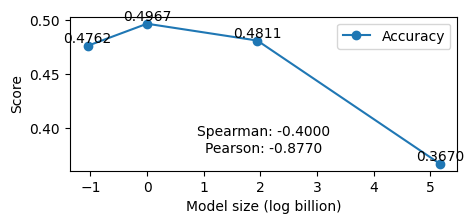

In [93]:
inputs, results = load_data("sampled_negated_lama")
probs, accs = compute_stats(inputs, results)
plot_curve(probs, accs)

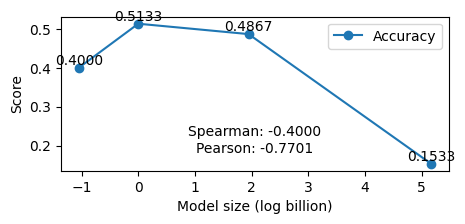

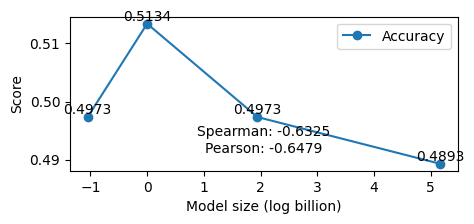

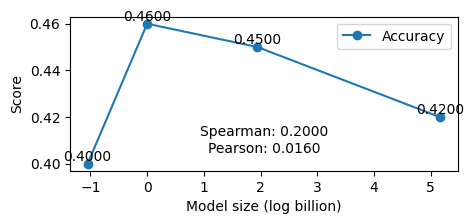

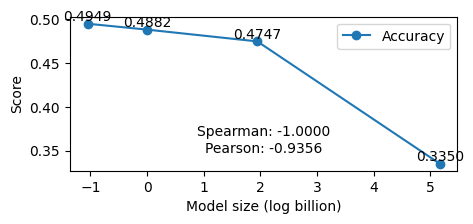

In [94]:
inputs, results = load_data("sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "ConceptNet")
plot_curve(probs, accs)

inputs, results = load_data("sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "GoogleRE")
plot_curve(probs, accs)

inputs, results = load_data("sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "SQUAD")
plot_curve(probs, accs)

inputs, results = load_data("sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "TREx")
plot_curve(probs, accs)

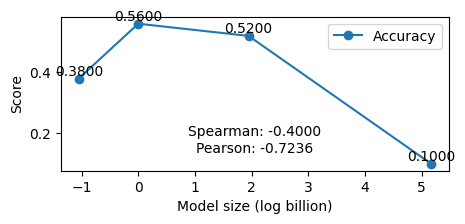

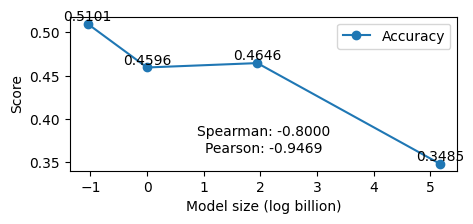

In [98]:
inputs, results = load_data("sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "ConceptNet" and x["metadata"]["category"] == "high_ranked")
plot_curve(probs, accs)

# inputs, results = load_data("sampled_negated_lama")
# probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "GoogleRE" and x["metadata"]["category"] == "high_ranked")
# plot_curve(probs, accs)

# inputs, results = load_data("sampled_negated_lama")
# probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "SQUAD" and x["metadata"]["category"] == "high_ranked")
# plot_curve(probs, accs)

inputs, results = load_data("sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "TREx" and x["metadata"]["category"] == "high_ranked")
plot_curve(probs, accs)

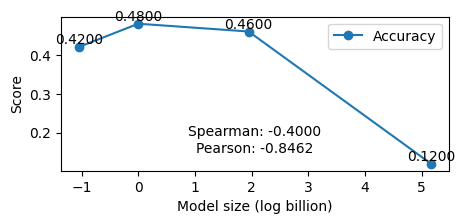

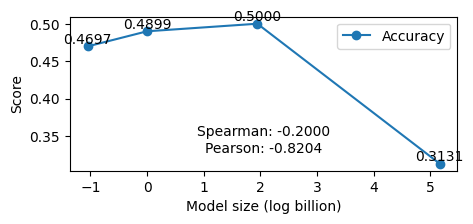

In [99]:
inputs, results = load_data("sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "ConceptNet" and x["metadata"]["category"] == "low_ranked")
plot_curve(probs, accs)

# inputs, results = load_data("sampled_negated_lama")
# probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "GoogleRE" and x["metadata"]["category"] == "low_ranked")
# plot_curve(probs, accs)

# inputs, results = load_data("sampled_negated_lama")
# probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "SQUAD" and x["metadata"]["category"] == "low_ranked")
# plot_curve(probs, accs)

inputs, results = load_data("sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "TREx" and x["metadata"]["category"] == "low_ranked")
plot_curve(probs, accs)

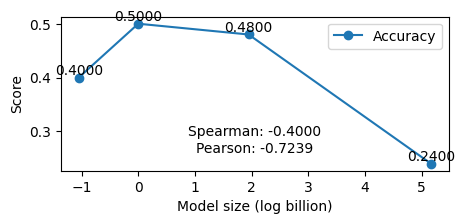

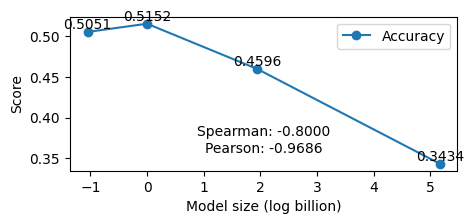

In [100]:
inputs, results = load_data("sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "ConceptNet" and x["metadata"]["category"] == "random")
plot_curve(probs, accs)

# inputs, results = load_data("sampled_negated_lama")
# probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "GoogleRE" and x["metadata"]["category"] == "random")
# plot_curve(probs, accs)

# inputs, results = load_data("sampled_negated_lama")
# probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "SQUAD" and x["metadata"]["category"] == "random")
# plot_curve(probs, accs)

inputs, results = load_data("sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "TREx" and x["metadata"]["category"] == "random")
plot_curve(probs, accs)

# OBQA

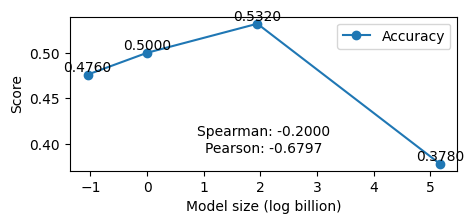

In [88]:
inputs, results = load_data("helm_sampled_data_rebalanced")
probs, accs = compute_stats(inputs, results)
plot_curve(probs, accs)

not/because


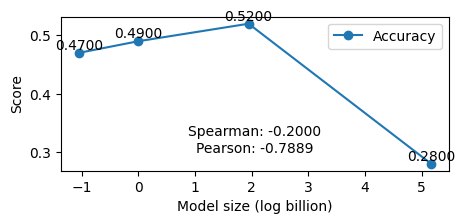

manual/un-in-


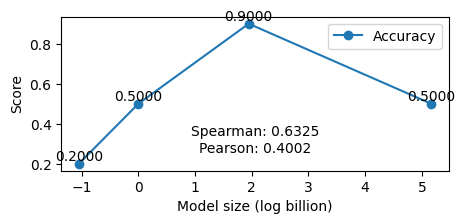

not/do


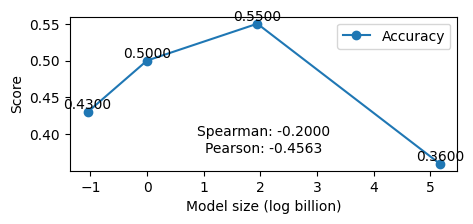

prompt


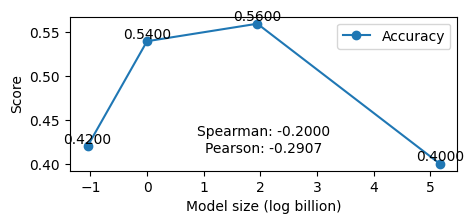

gold/un-in-


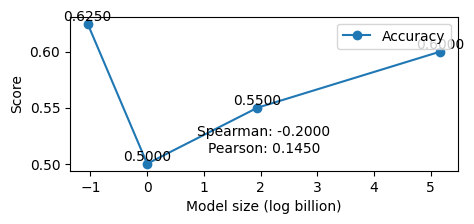

not/be


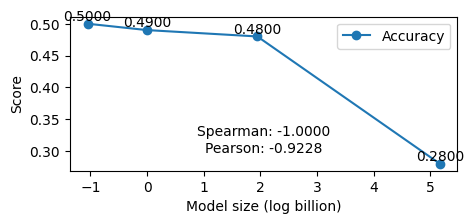

not/modal


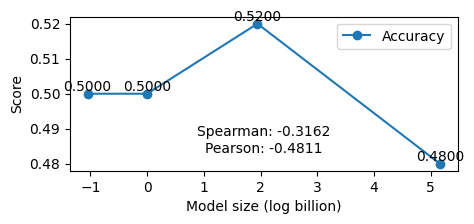

un-in-


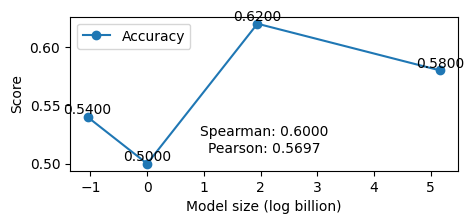

In [90]:
negation_rules = set([item["negation_rule"] for item in inputs])

for rule in negation_rules:
    print(rule)
    inputs, results = load_data("helm_sampled_data_rebalanced")
    probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["negation_rule"] == rule)
    plot_curve(probs, accs)

print("un-in-")
inputs, results = load_data("helm_sampled_data_rebalanced")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: "un-in-" in x["negation_rule"])
plot_curve(probs, accs)

# Normal LAMA

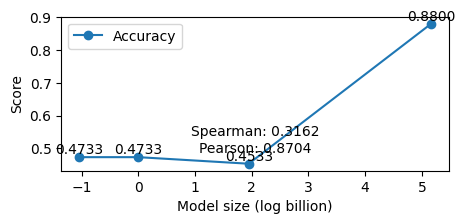

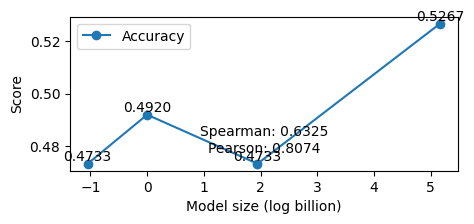

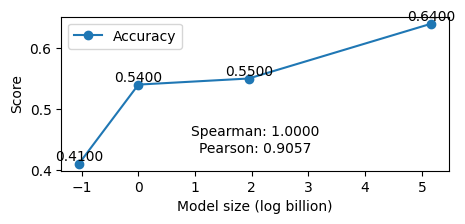

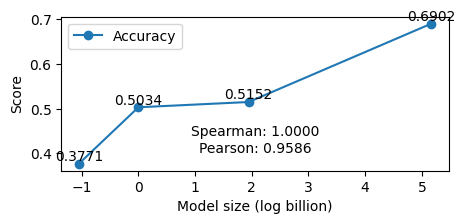

In [2]:
inputs, results = load_data("sampled_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "ConceptNet")
plot_curve(probs, accs)

inputs, results = load_data("sampled_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "GoogleRE")
plot_curve(probs, accs)

inputs, results = load_data("sampled_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "SQUAD")
plot_curve(probs, accs)

inputs, results = load_data("sampled_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "TREx")
plot_curve(probs, accs)

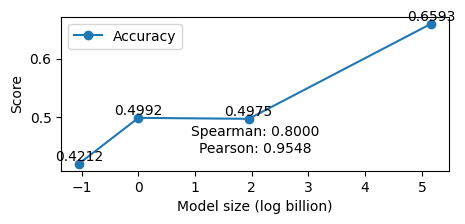

In [3]:
inputs, results = load_data("sampled_lama")
probs, accs = compute_stats(inputs, results)
plot_curve(probs, accs)

# CSQA

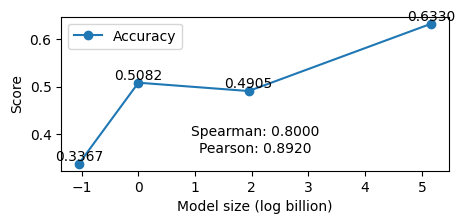

In [5]:
inputs, results = load_data("csqa_gold_no")
probs, accs = compute_stats(inputs, results)
plot_curve(probs, accs)

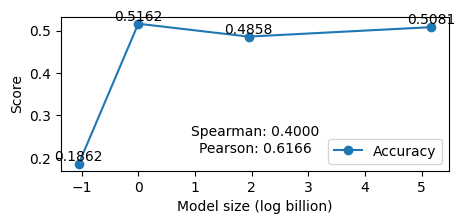

In [7]:
inputs, results = load_data("csqa2_gold_no")
probs, accs = compute_stats(inputs, results)
plot_curve(probs, accs)

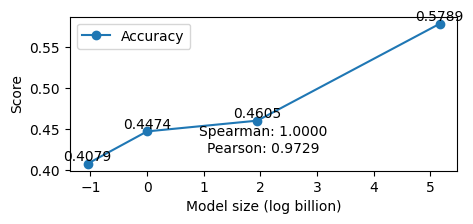

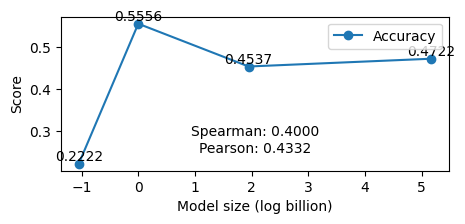

In [13]:
inputs, results = load_data("csqa_gold_no")
probs, accs = compute_stats(inputs, results, lambda x: "is not" in x["question"]["stem"])
plot_curve(probs, accs)

inputs, results = load_data("csqa2_gold_no")
probs, accs = compute_stats(inputs, results, lambda x: "is not" in x["question"]["stem"])
plot_curve(probs, accs)

In [14]:
inputs, results = load_data("csqa_be_not")
probs, accs = compute_stats(inputs, results)
plot_curve(probs, accs)

FileNotFoundError: [Errno 2] No such file or directory: 'csqa_be_not/commonsense:dataset=openbookqa,method=multiple_choice_joint,model=openai_ada/per_instance_stats.json'

# Misprimed Negated LAMA

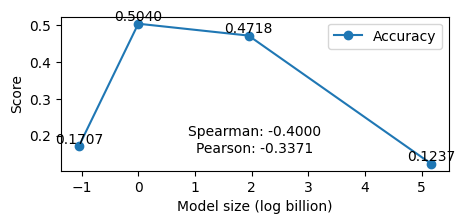

In [3]:
inputs, results = load_data("misprimed_sampled_negated_lama")
probs, accs = compute_stats(inputs, results)
plot_curve(probs, accs)

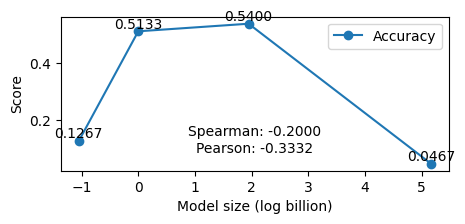

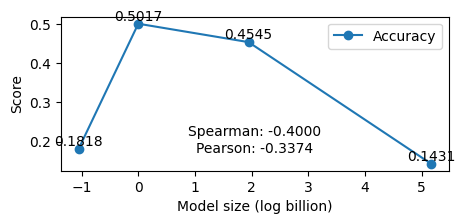

In [4]:
inputs, results = load_data("misprimed_sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "ConceptNet")
plot_curve(probs, accs)

inputs, results = load_data("misprimed_sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "TREx")
plot_curve(probs, accs)

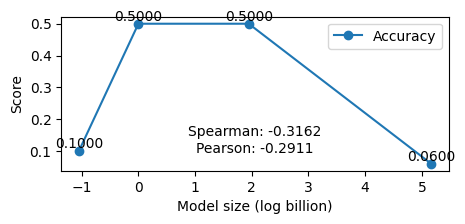

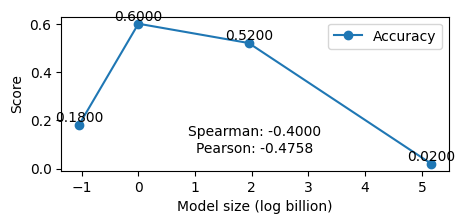

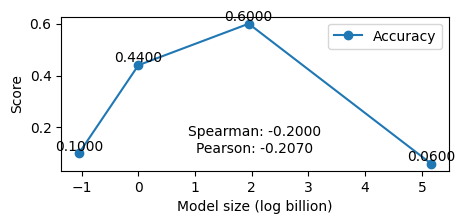

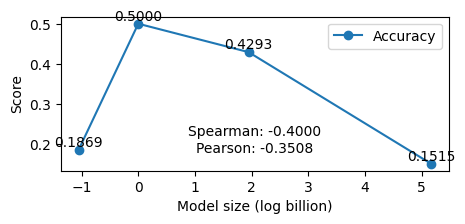

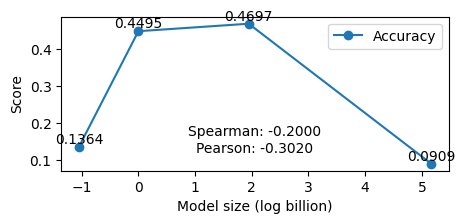

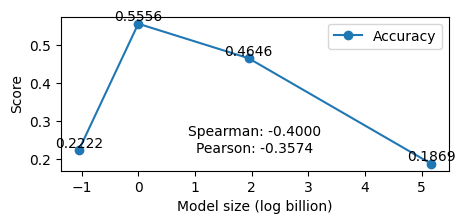

In [6]:
inputs, results = load_data("misprimed_sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "ConceptNet" and x["metadata"]["category"] == "high_ranked")
plot_curve(probs, accs)
inputs, results = load_data("misprimed_sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "ConceptNet" and x["metadata"]["category"] == "low_ranked")
plot_curve(probs, accs)
inputs, results = load_data("misprimed_sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "ConceptNet" and x["metadata"]["category"] == "random")
plot_curve(probs, accs)

inputs, results = load_data("misprimed_sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "TREx" and x["metadata"]["category"] == "high_ranked")
plot_curve(probs, accs)
inputs, results = load_data("misprimed_sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "TREx" and x["metadata"]["category"] == "low_ranked")
plot_curve(probs, accs)
inputs, results = load_data("misprimed_sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "TREx" and x["metadata"]["category"] == "random")
plot_curve(probs, accs)

# Consistency Analysis

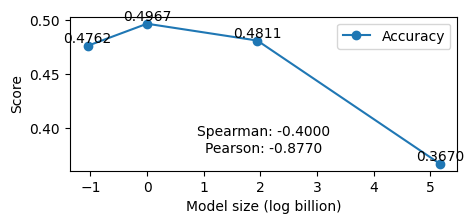

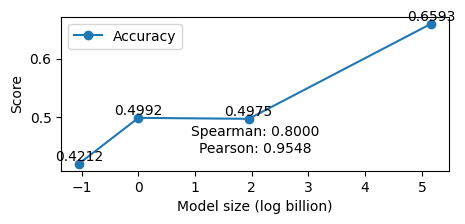

[0.8661740558292282, 0.9080459770114943, 0.8604269293924466, 0.9302134646962233]


In [18]:
inputs, results, predictions_negated = load_data("sampled_negated_lama", return_predictions=True)
probs, accs = compute_stats(inputs, results)
plot_curve(probs, accs)

inputs, results, predictions_original = load_data("sampled_lama", return_predictions=True)
probs, accs = compute_stats(inputs, results)
plot_curve(probs, accs)

consistencies = [(np.array(predictions_negated[i]) == np.array(predictions_original[i])).mean() for i in range(len(predictions_negated))]
print(consistencies)

In [13]:
results[0]

{'question': {'stem': 'Drums is not made of ___?',
  'choices': [{'text': 'wood', 'label': 'A'},
   {'text': 'steel', 'label': 'B'}]},
 'answerKey': 'B',
 'metadata': {'dataset': 'ConceptNet',
  'category': 'high_ranked',
  'subdataset': 'ConceptNet.jsonl',
  'idx': 112}}

In [12]:
predictions

[[' B',
  ' B',
  ' F',
  ' B',
  ' A',
  ' B',
  ' B',
  ' B',
  ' noun',
  ' B',
  ' D',
  ' B',
  ' B',
  ' B',
  ' B',
  ' A',
  ' A',
  ' B',
  ' A',
  ' B',
  ' A',
  ' A',
  ' A',
  ' C',
  ' B',
  ' A',
  ' B',
  ' B',
  ' B',
  ' B',
  ' Study',
  ' B',
  ' B',
  ' A',
  ' A',
  ' A',
  ' B',
  ' Sc',
  ' B',
  ' B',
  ' Sword',
  ' A',
  ' B',
  ' Kind',
  ' Depend',
  ' B',
  ' B',
  ' A',
  ' B',
  ' B',
  ' A',
  ' B',
  ' B',
  ' B',
  ' B',
  ' B',
  ' B',
  ' B',
  ' A',
  ' B',
  ' B',
  ' B',
  ' B',
  ' A',
  ' Cr',
  ' A',
  ' A',
  ' B',
  ' B',
  ' A',
  ' B',
  ' A',
  ' A',
  ' A',
  ' A',
  ' Relax',
  ' B',
  ' B',
  ' B',
  ' B',
  ' B',
  ' B',
  ' B',
  ' A',
  ' B',
  ' B',
  ' A',
  ' B',
  ' B',
  ' B',
  ' B',
  ' B',
  ' A',
  ' B',
  ' B',
  ' B',
  ' Dis',
  ' A',
  ' A',
  ' B',
  ' B',
  ' B',
  ' Study',
  ' A',
  ' B',
  ' A',
  ' A',
  ' B',
  ' A',
  ' B',
  ' A',
  ' B',
  ' B',
  ' B',
  ' A',
  ' B',
  ' A',
  ' A',
  ' B',
  ' B',
  ' B',
 

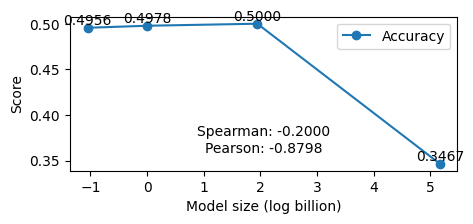

In [20]:
inputs, results = load_data("obqa_original")
probs, accs = compute_stats(inputs, results)
plot_curve(probs, accs)